In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
import shap
shap.initjs()

In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['smiles'])


In [5]:
from rdkit.Chem import Descriptors

# Use list comprehensions to store the names and functions of RDKit molecular descriptors in a dictionary
all_descriptors = {name: func for name, func in Descriptors.descList}

In [6]:
rdkit_list = list(all_descriptors.keys())
rdkit_list

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VS

In [7]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [8]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

In [9]:
data_rdkit_mask = vt.get_support(indices=True)

In [10]:
train_dataset

<NumpyDataset X.shape: (390, 164), y.shape: (390,), w.shape: (390,), ids: [206 477 392 ... 38 327 261], task_names: [0]>

# t-SNE

<Axes: >

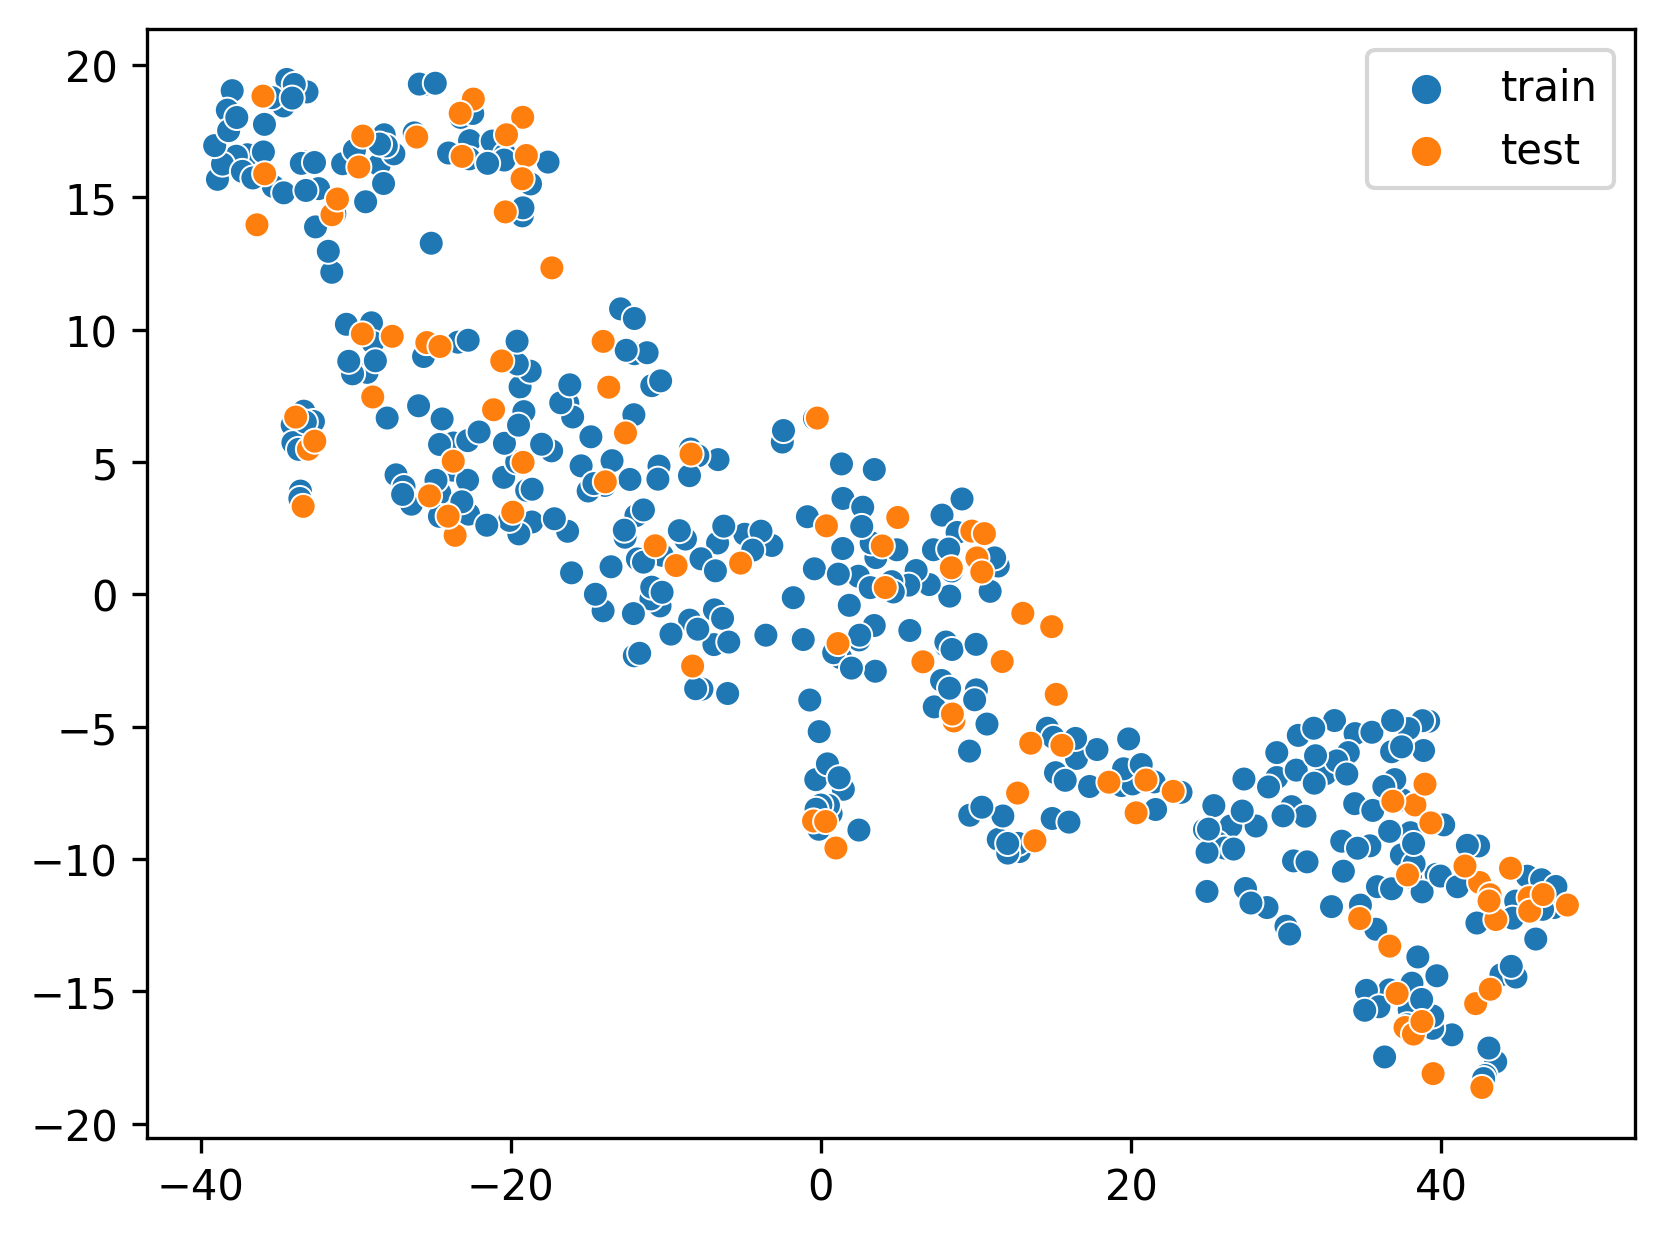

In [11]:
data_rdkit = np.concatenate((train_dataset.X, test_dataset.X), axis=0)

tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(data_rdkit)

sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*390 + ['test']*98)

# GridSearchCV

In [12]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

classifier  =  RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators':[80,100,120,140,160,180,200,220,240,260],
              'max_depth':[5,8,10,20,30,40],
            'max_features':["auto", "sqrt", "log2"]}

rf_gs = GridSearchCV(
                    classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [13]:
val_AUC = rf_gs.best_score_
val_ACC = rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_]
val_PRE = rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_]
val_REC = rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_]

In [14]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (AUC): ', rf_gs.best_score_)
print('ACC: ', rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_])
print('PRE: ', rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_])
print('REC: ',rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 260}
Best score (AUC):  0.9268457222127087
ACC:  0.8487179487179487
PRE:  0.8230953143996622
REC:  0.8907306349411612


In [15]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=8, n_estimators=260, random_state=42)

# Model evaluation

In [16]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

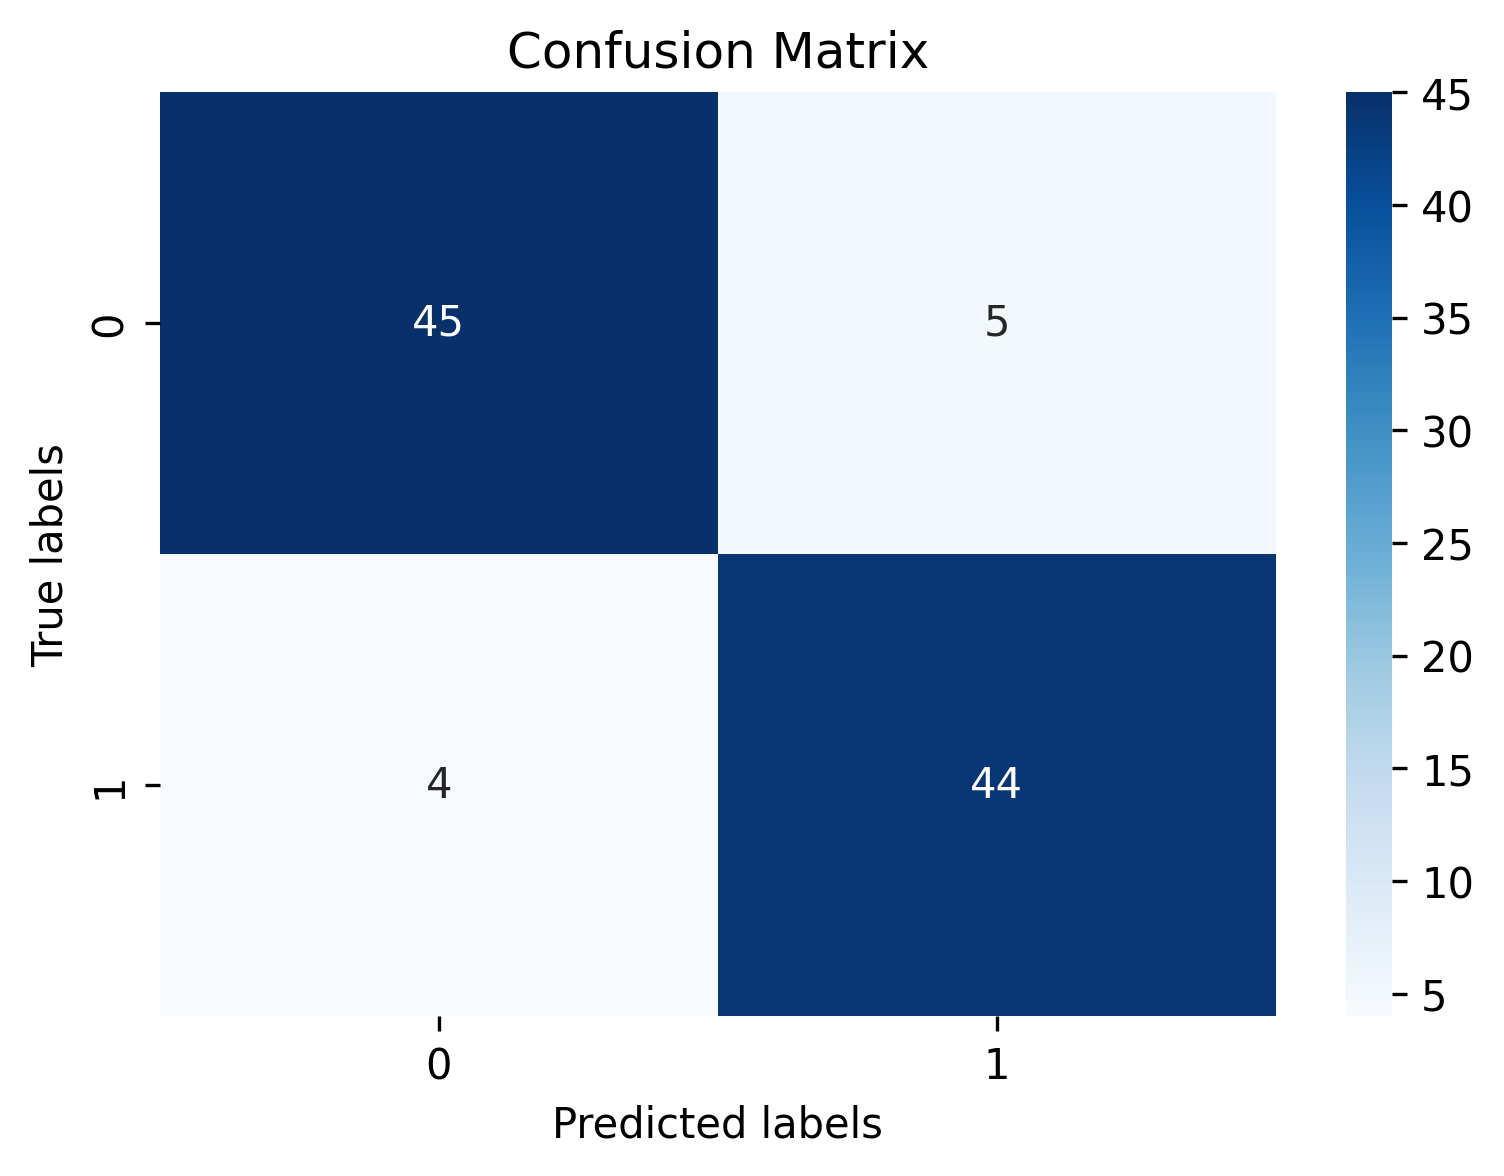

In [18]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [19]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [20]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [21]:
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(rf_test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(rf_test_pred_array))

In [22]:
rf_performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [23]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

AUC       ACC       PRE       REC
val   0.926846  0.848718  0.823095  0.890731
test  0.976667  0.908163  0.897959  0.916667

In [19]:
import pickle


with open('rf_rdkit_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Ave_confusion_matrix

In [2]:
#the average of five different random seeds
confusion_mat_ave = np.array([[42.2,5],
                              [5.6,45.2]])

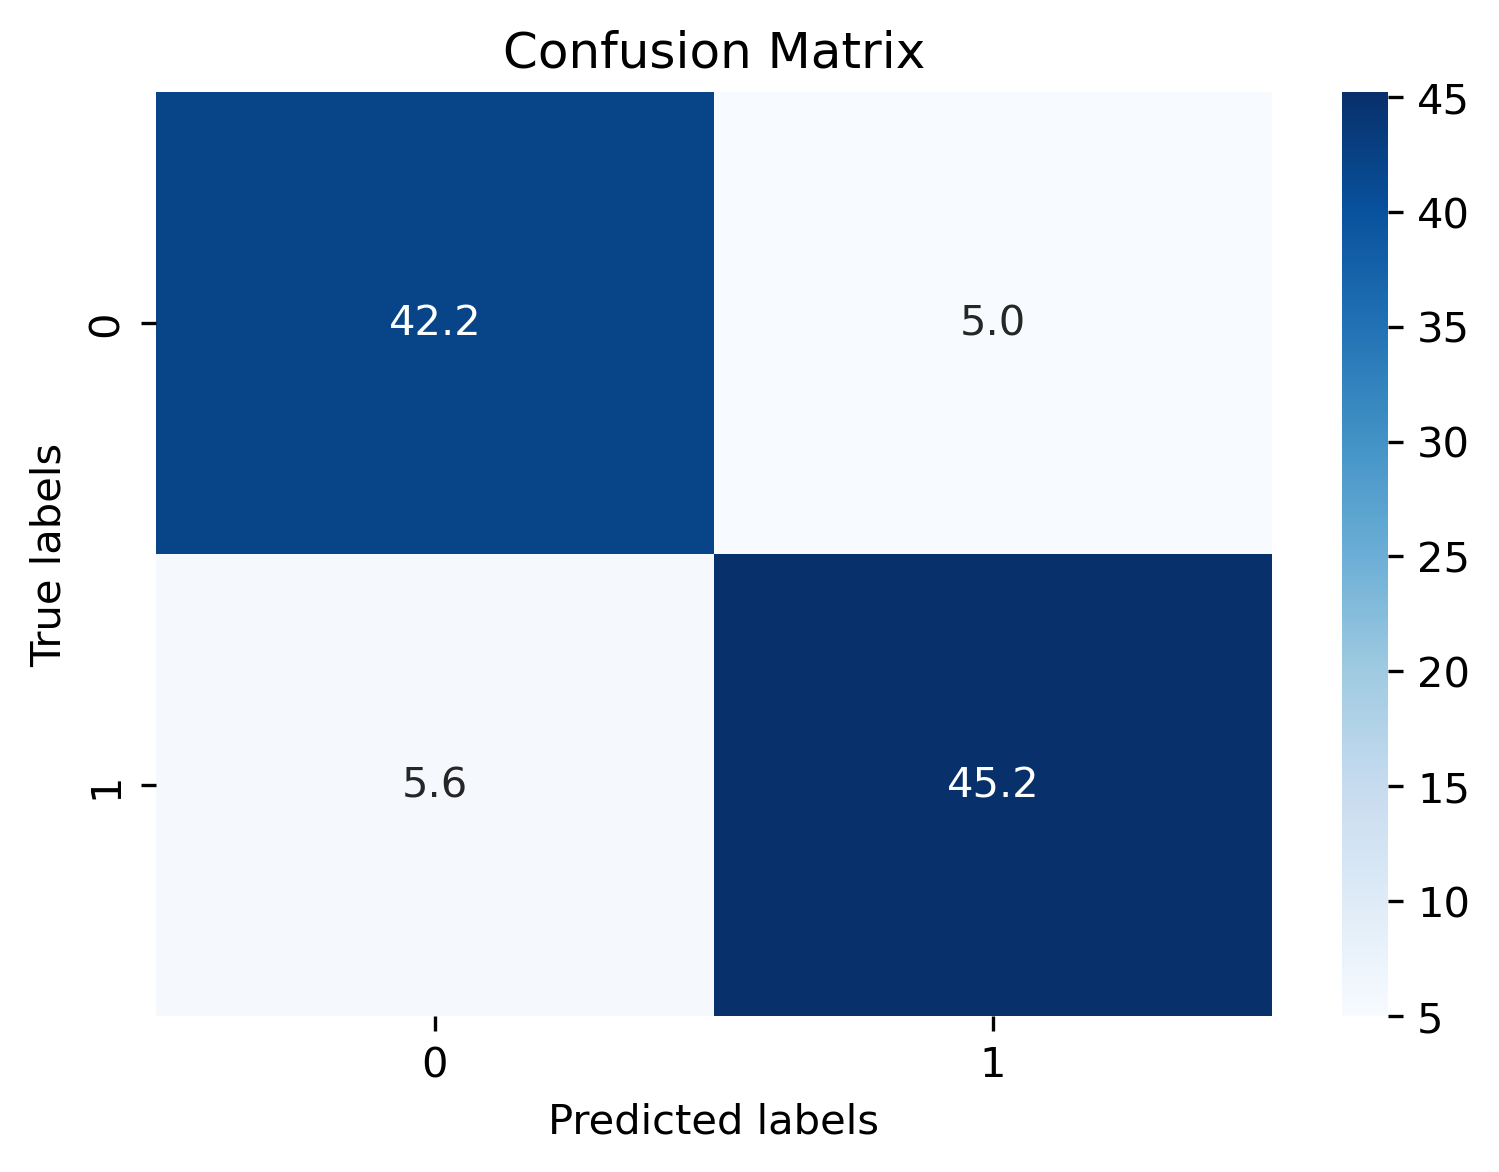

In [3]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# SHAP

In [17]:
result = [rdkit_list[i] for i in data_rdkit_mask]

In [18]:
explainer = shap.TreeExplainer(rf_model,feature_names=result)
shap_values = explainer.shap_values(test_dataset.X)

In [19]:
test_data = pd.DataFrame(test_dataset.X, columns=result)

<Figure size 3600x2400 with 0 Axes>

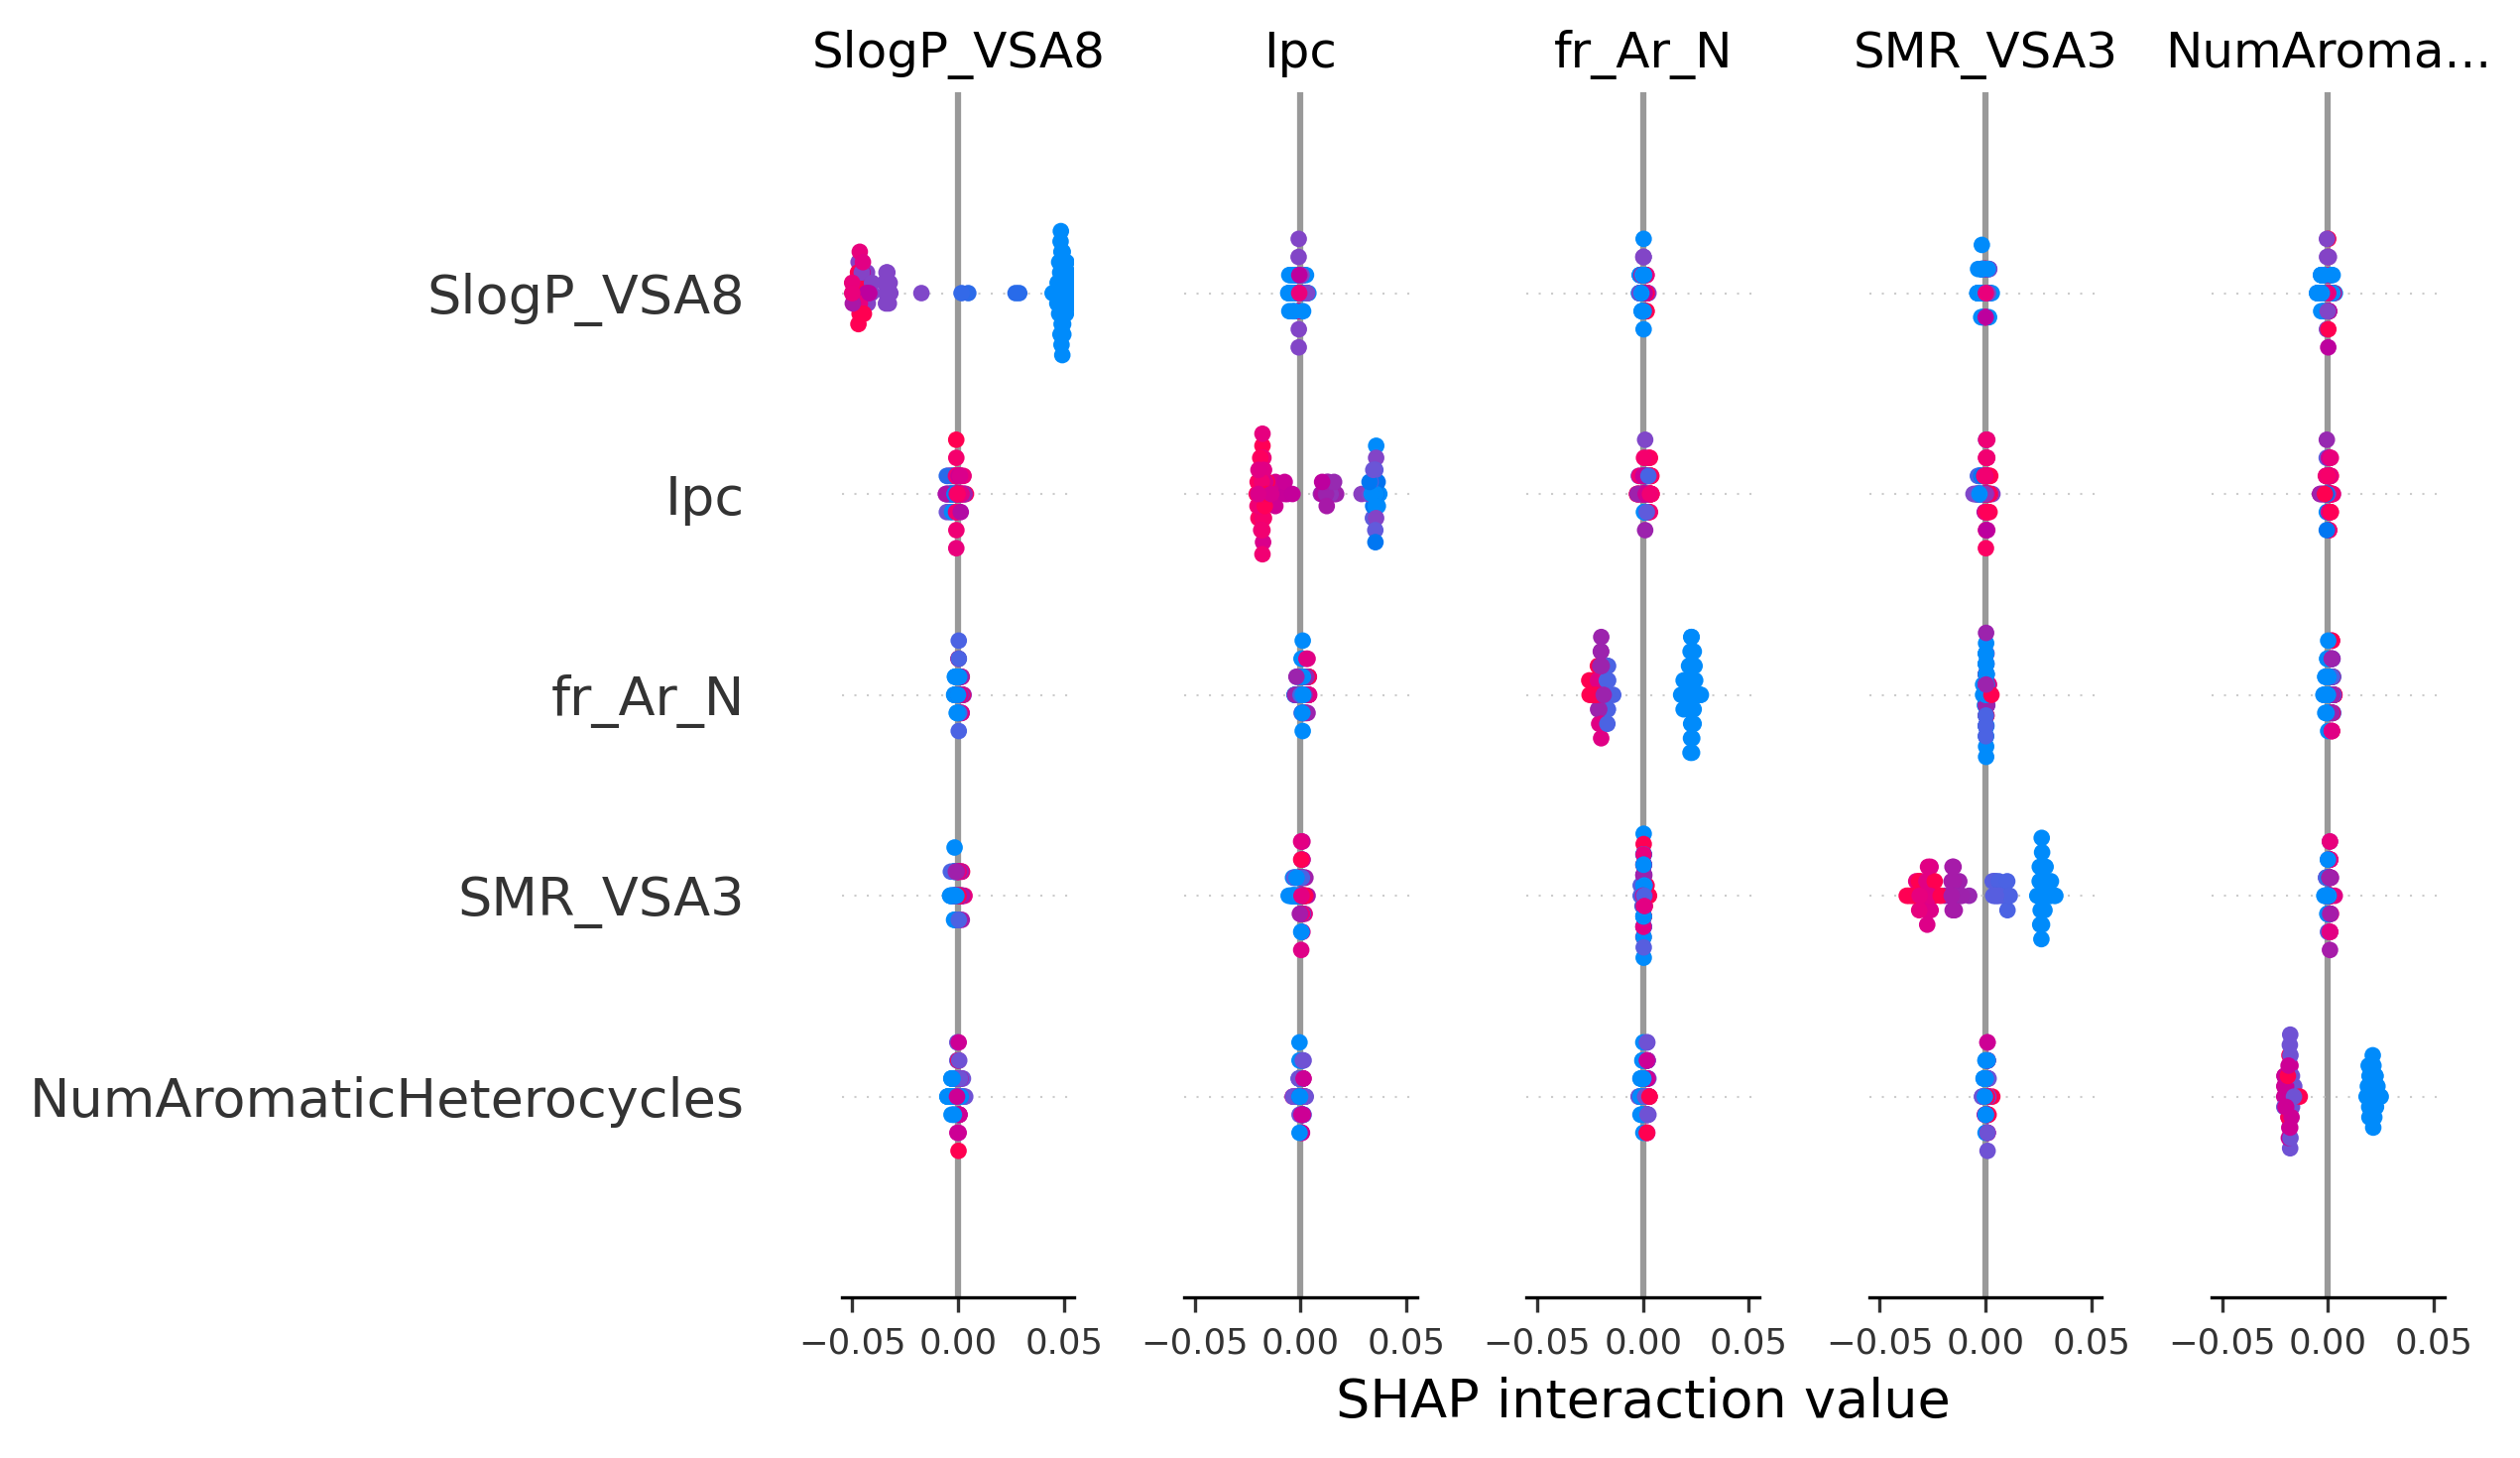

In [48]:
plt.figure(figsize=(12, 8)) 
shap_interaction_values = explainer.shap_interaction_values(test_dataset.X)
shap.summary_plot(shap_interaction_values[1],test_data, max_display=5,show=False)

fig = plt.gcf()
ax = fig.axes[0]
ax1 = fig.axes[1]
ax2 = fig.axes[2]
ax3 = fig.axes[3]
ax4 = fig.axes[4]

# Set X-axis label rotation
plt.setp(ax.get_xticklabels(), fontsize=8.5)
plt.setp(ax1.get_xticklabels(),fontsize=8.5)
plt.setp(ax2.get_xticklabels(),fontsize=8.5)
plt.setp(ax3.get_xticklabels(),fontsize=8.5)
plt.setp(ax4.get_xticklabels(),fontsize=8.5)

plt.tight_layout()
plt.show()

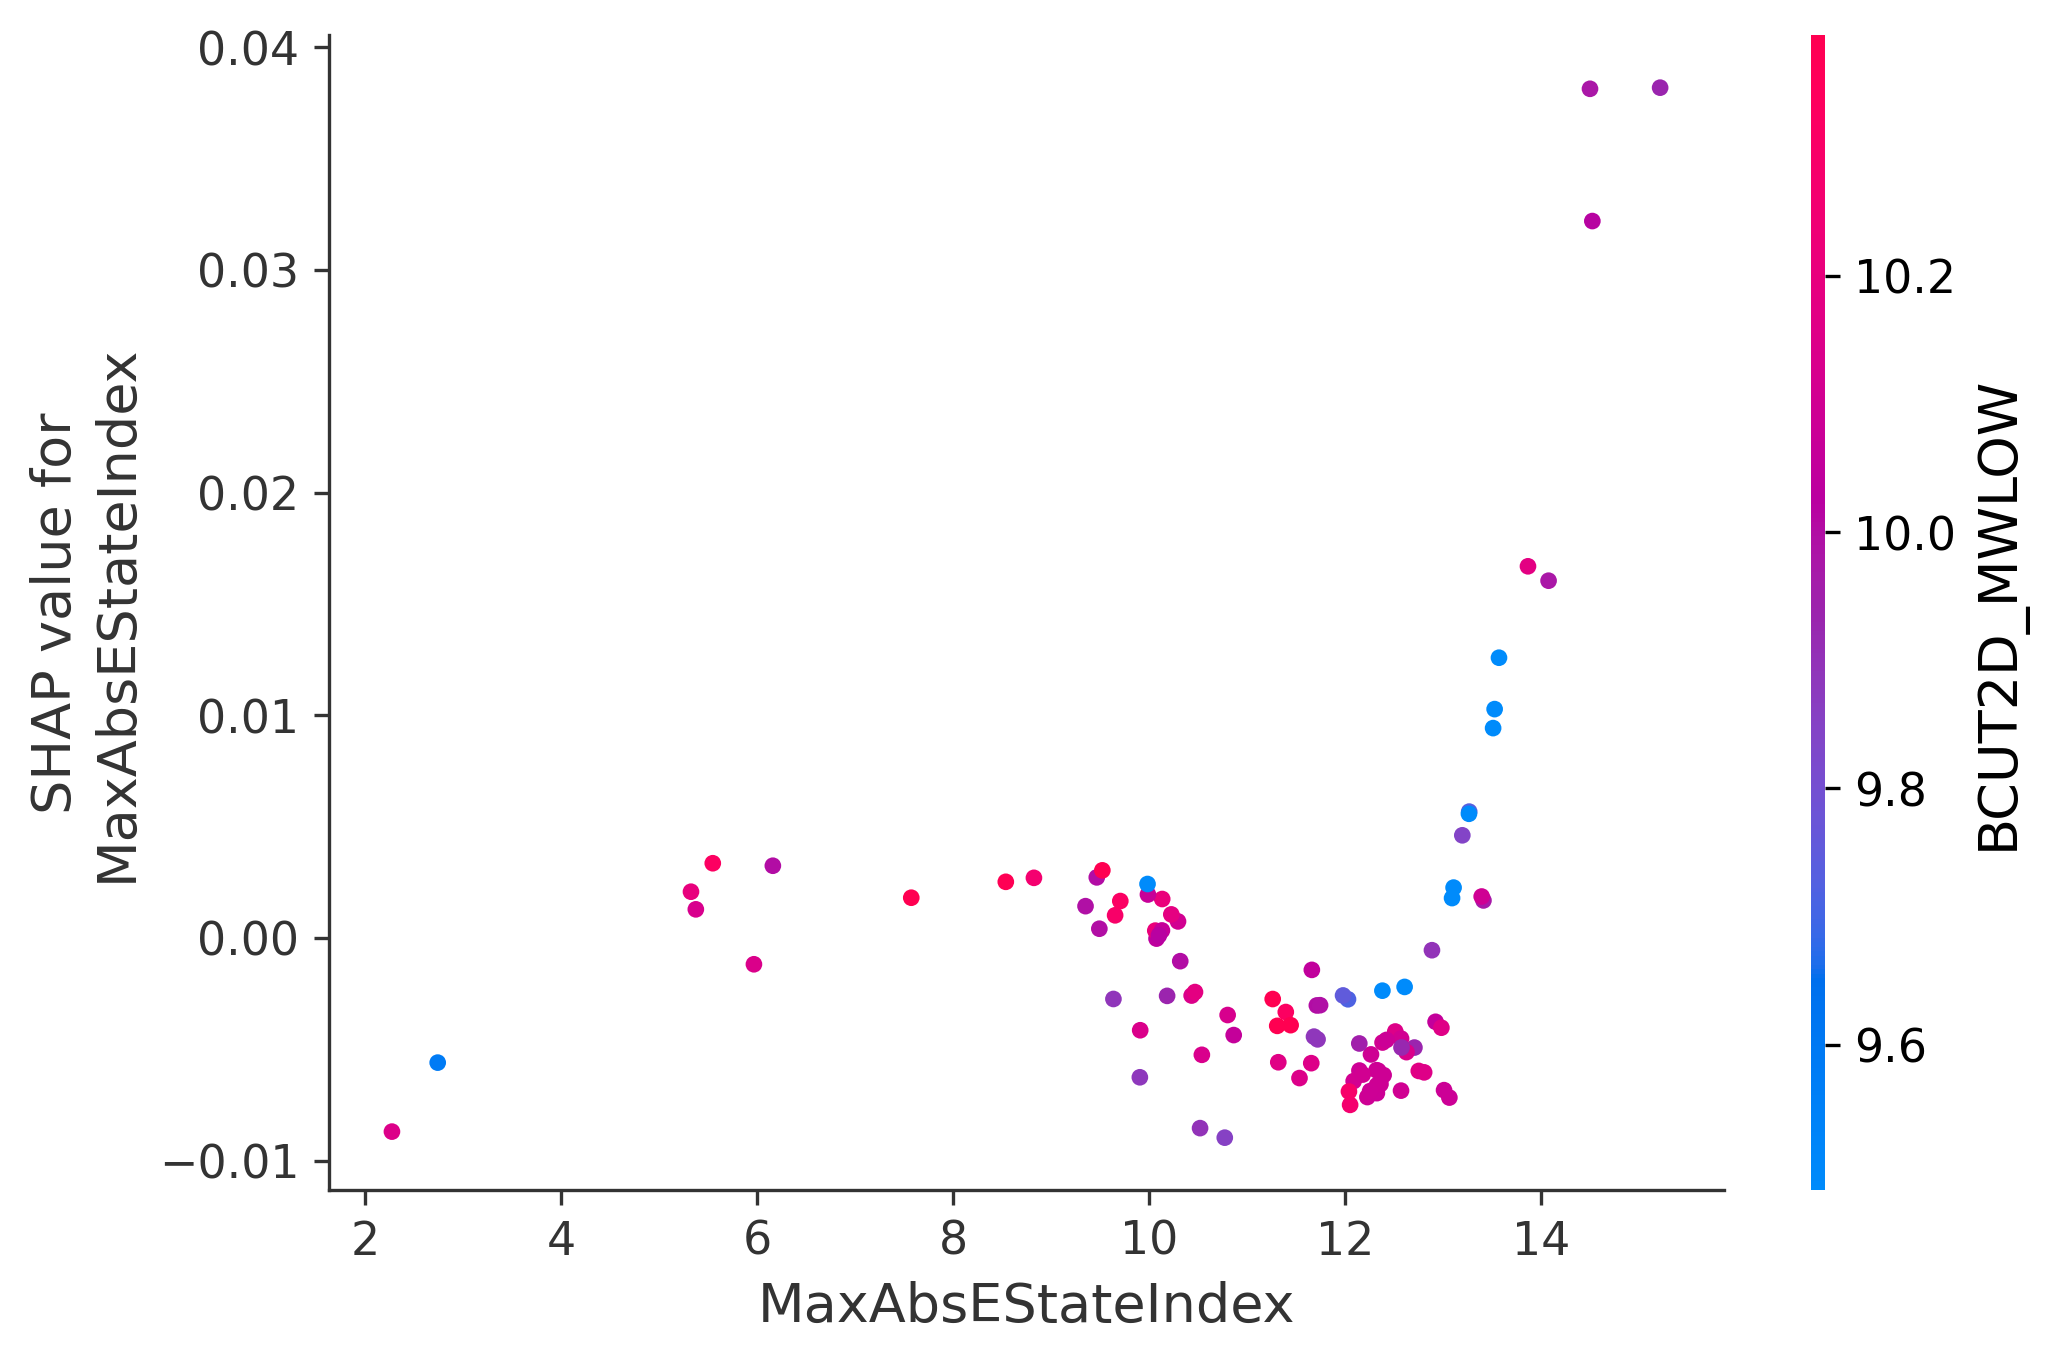

In [35]:
shap.dependence_plot("MaxAbsEStateIndex",shap_values[1], test_dataset.X,feature_names=result,display_features=test_dataset.X)

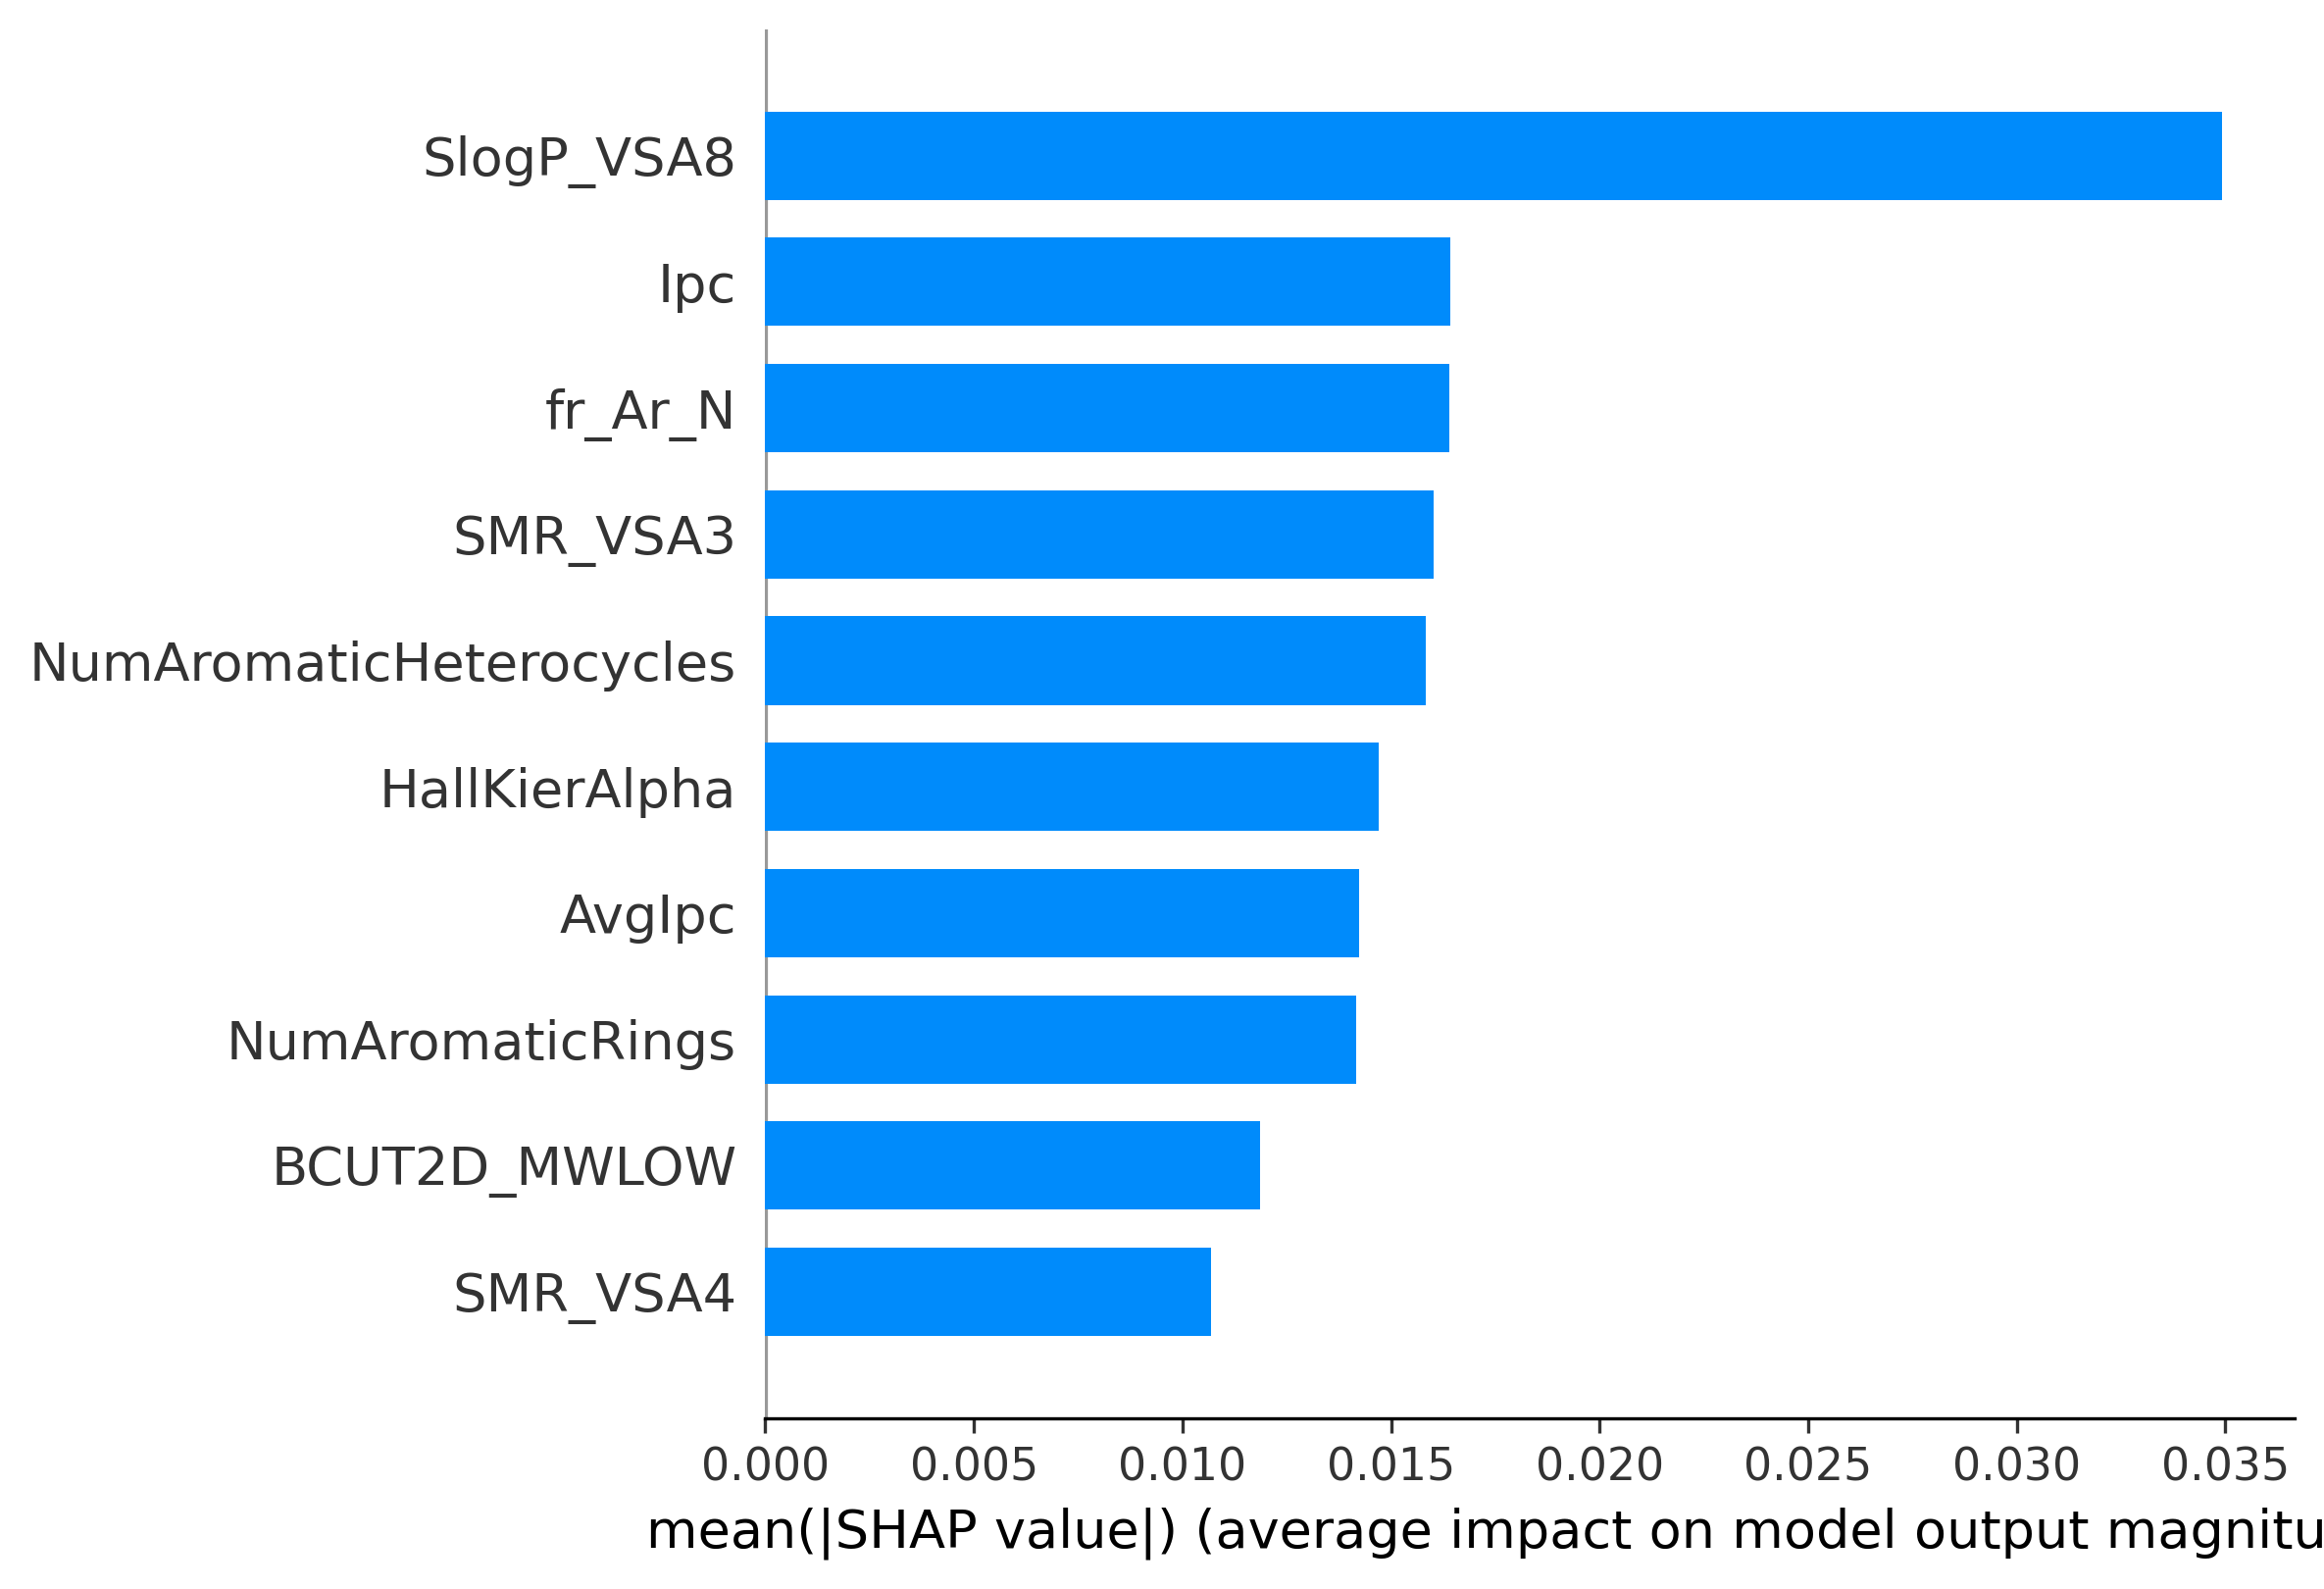

In [65]:
shap.summary_plot(shap_values[1], test_dataset.X, plot_type="bar", max_display=10,feature_names = selected_rdkit_list)

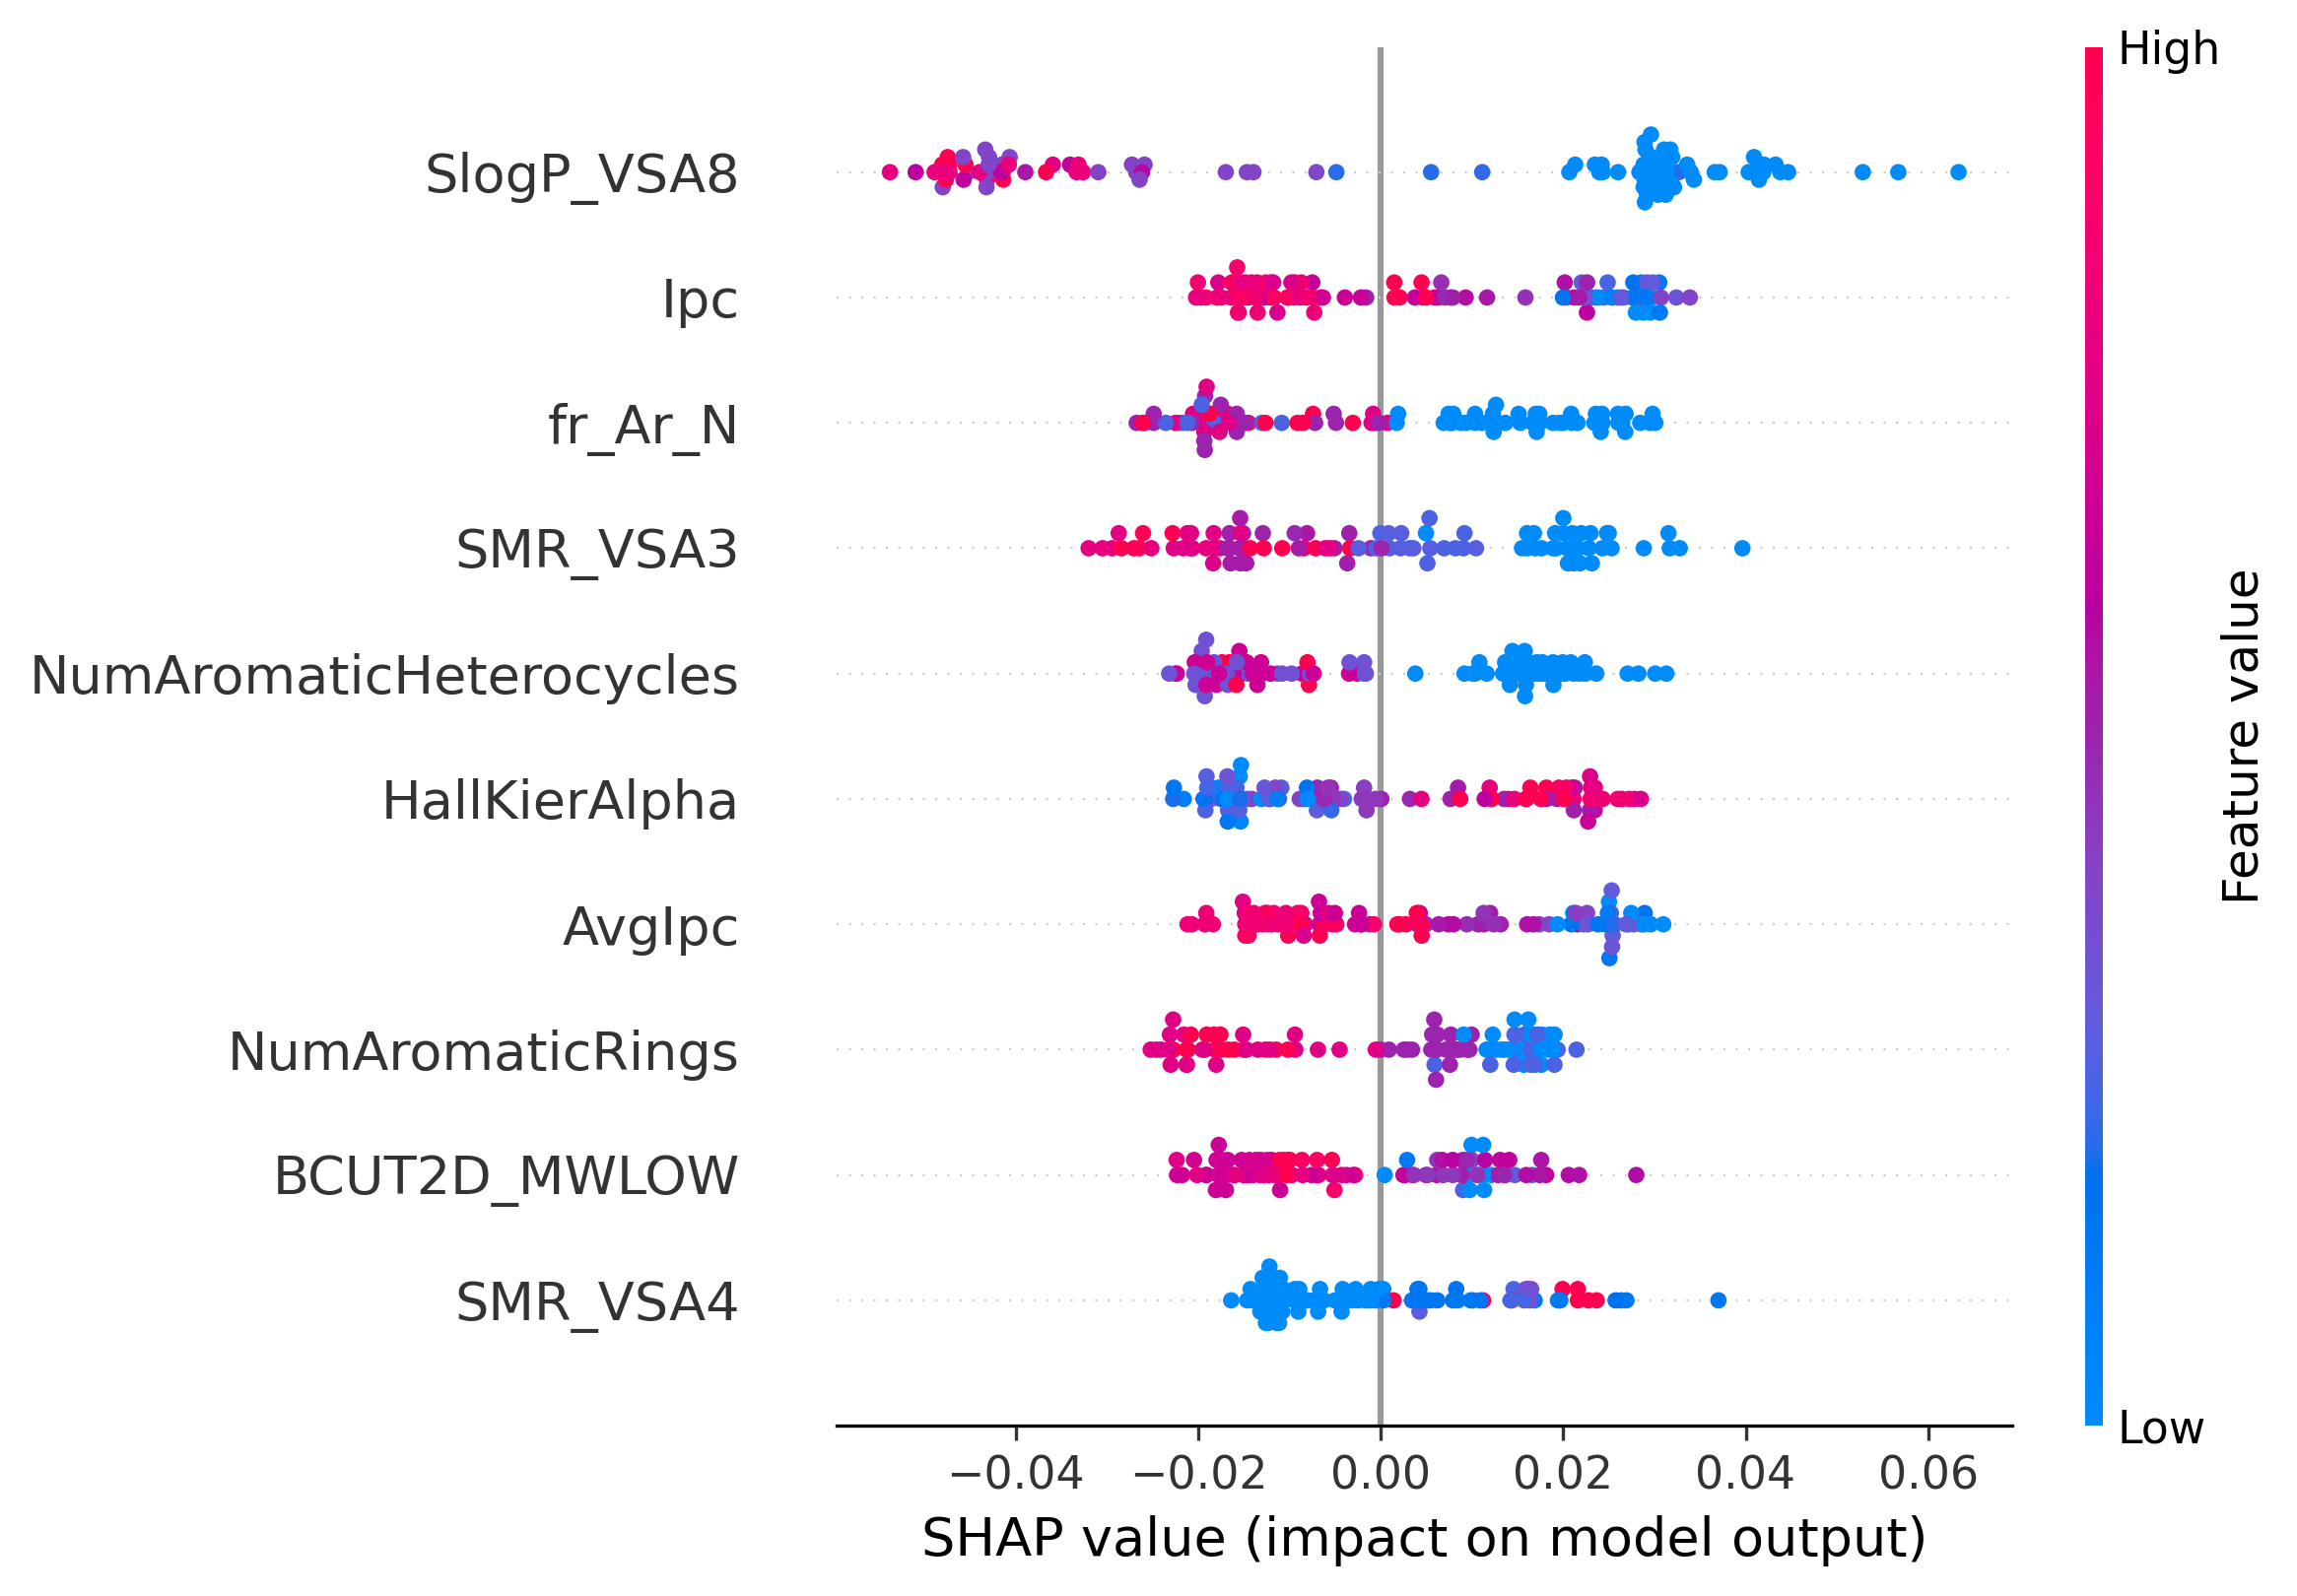

In [38]:
shap.summary_plot(shap_values[1], test_dataset.X,max_display=10,feature_names = result)

In [41]:
expected_values = explainer.expected_value

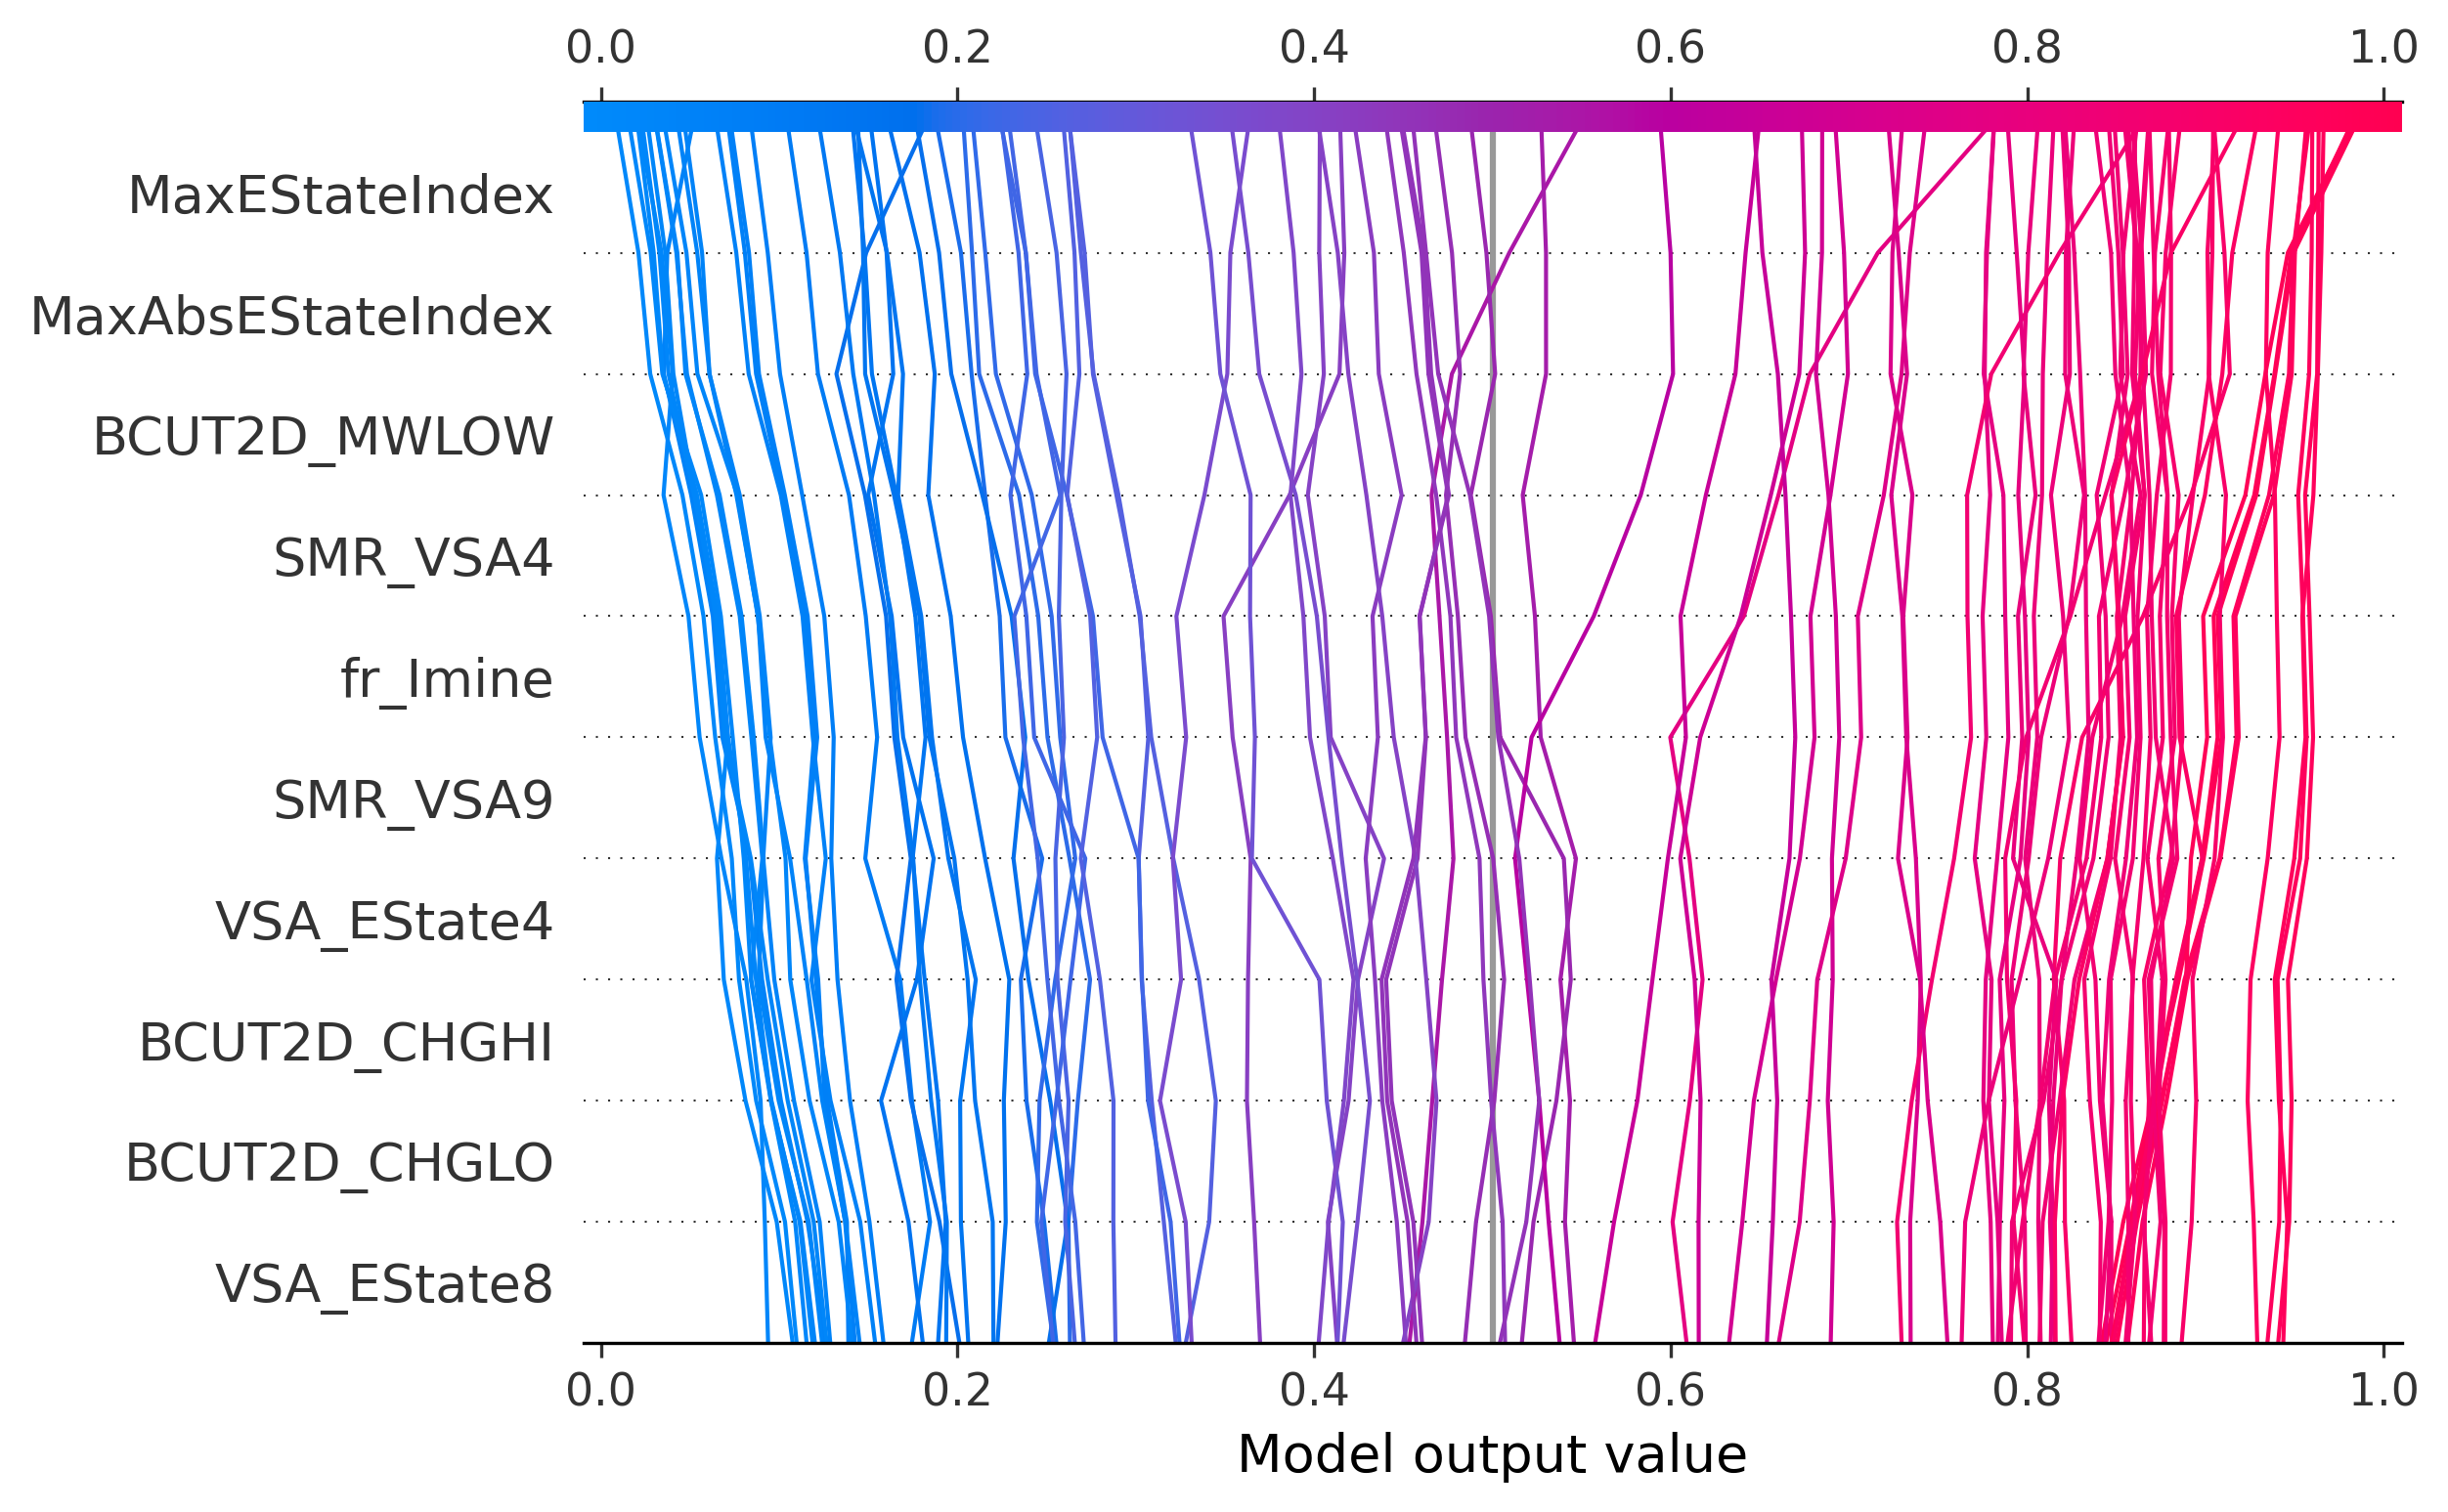

In [43]:
shap.decision_plot(expected_values[1], shap_values[1], test_dataset.X, feature_names = result, feature_order='hclust',feature_display_range=slice(None,-11,-1))

# global_force_plot

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values[1],test_dataset.X,feature_names = result)

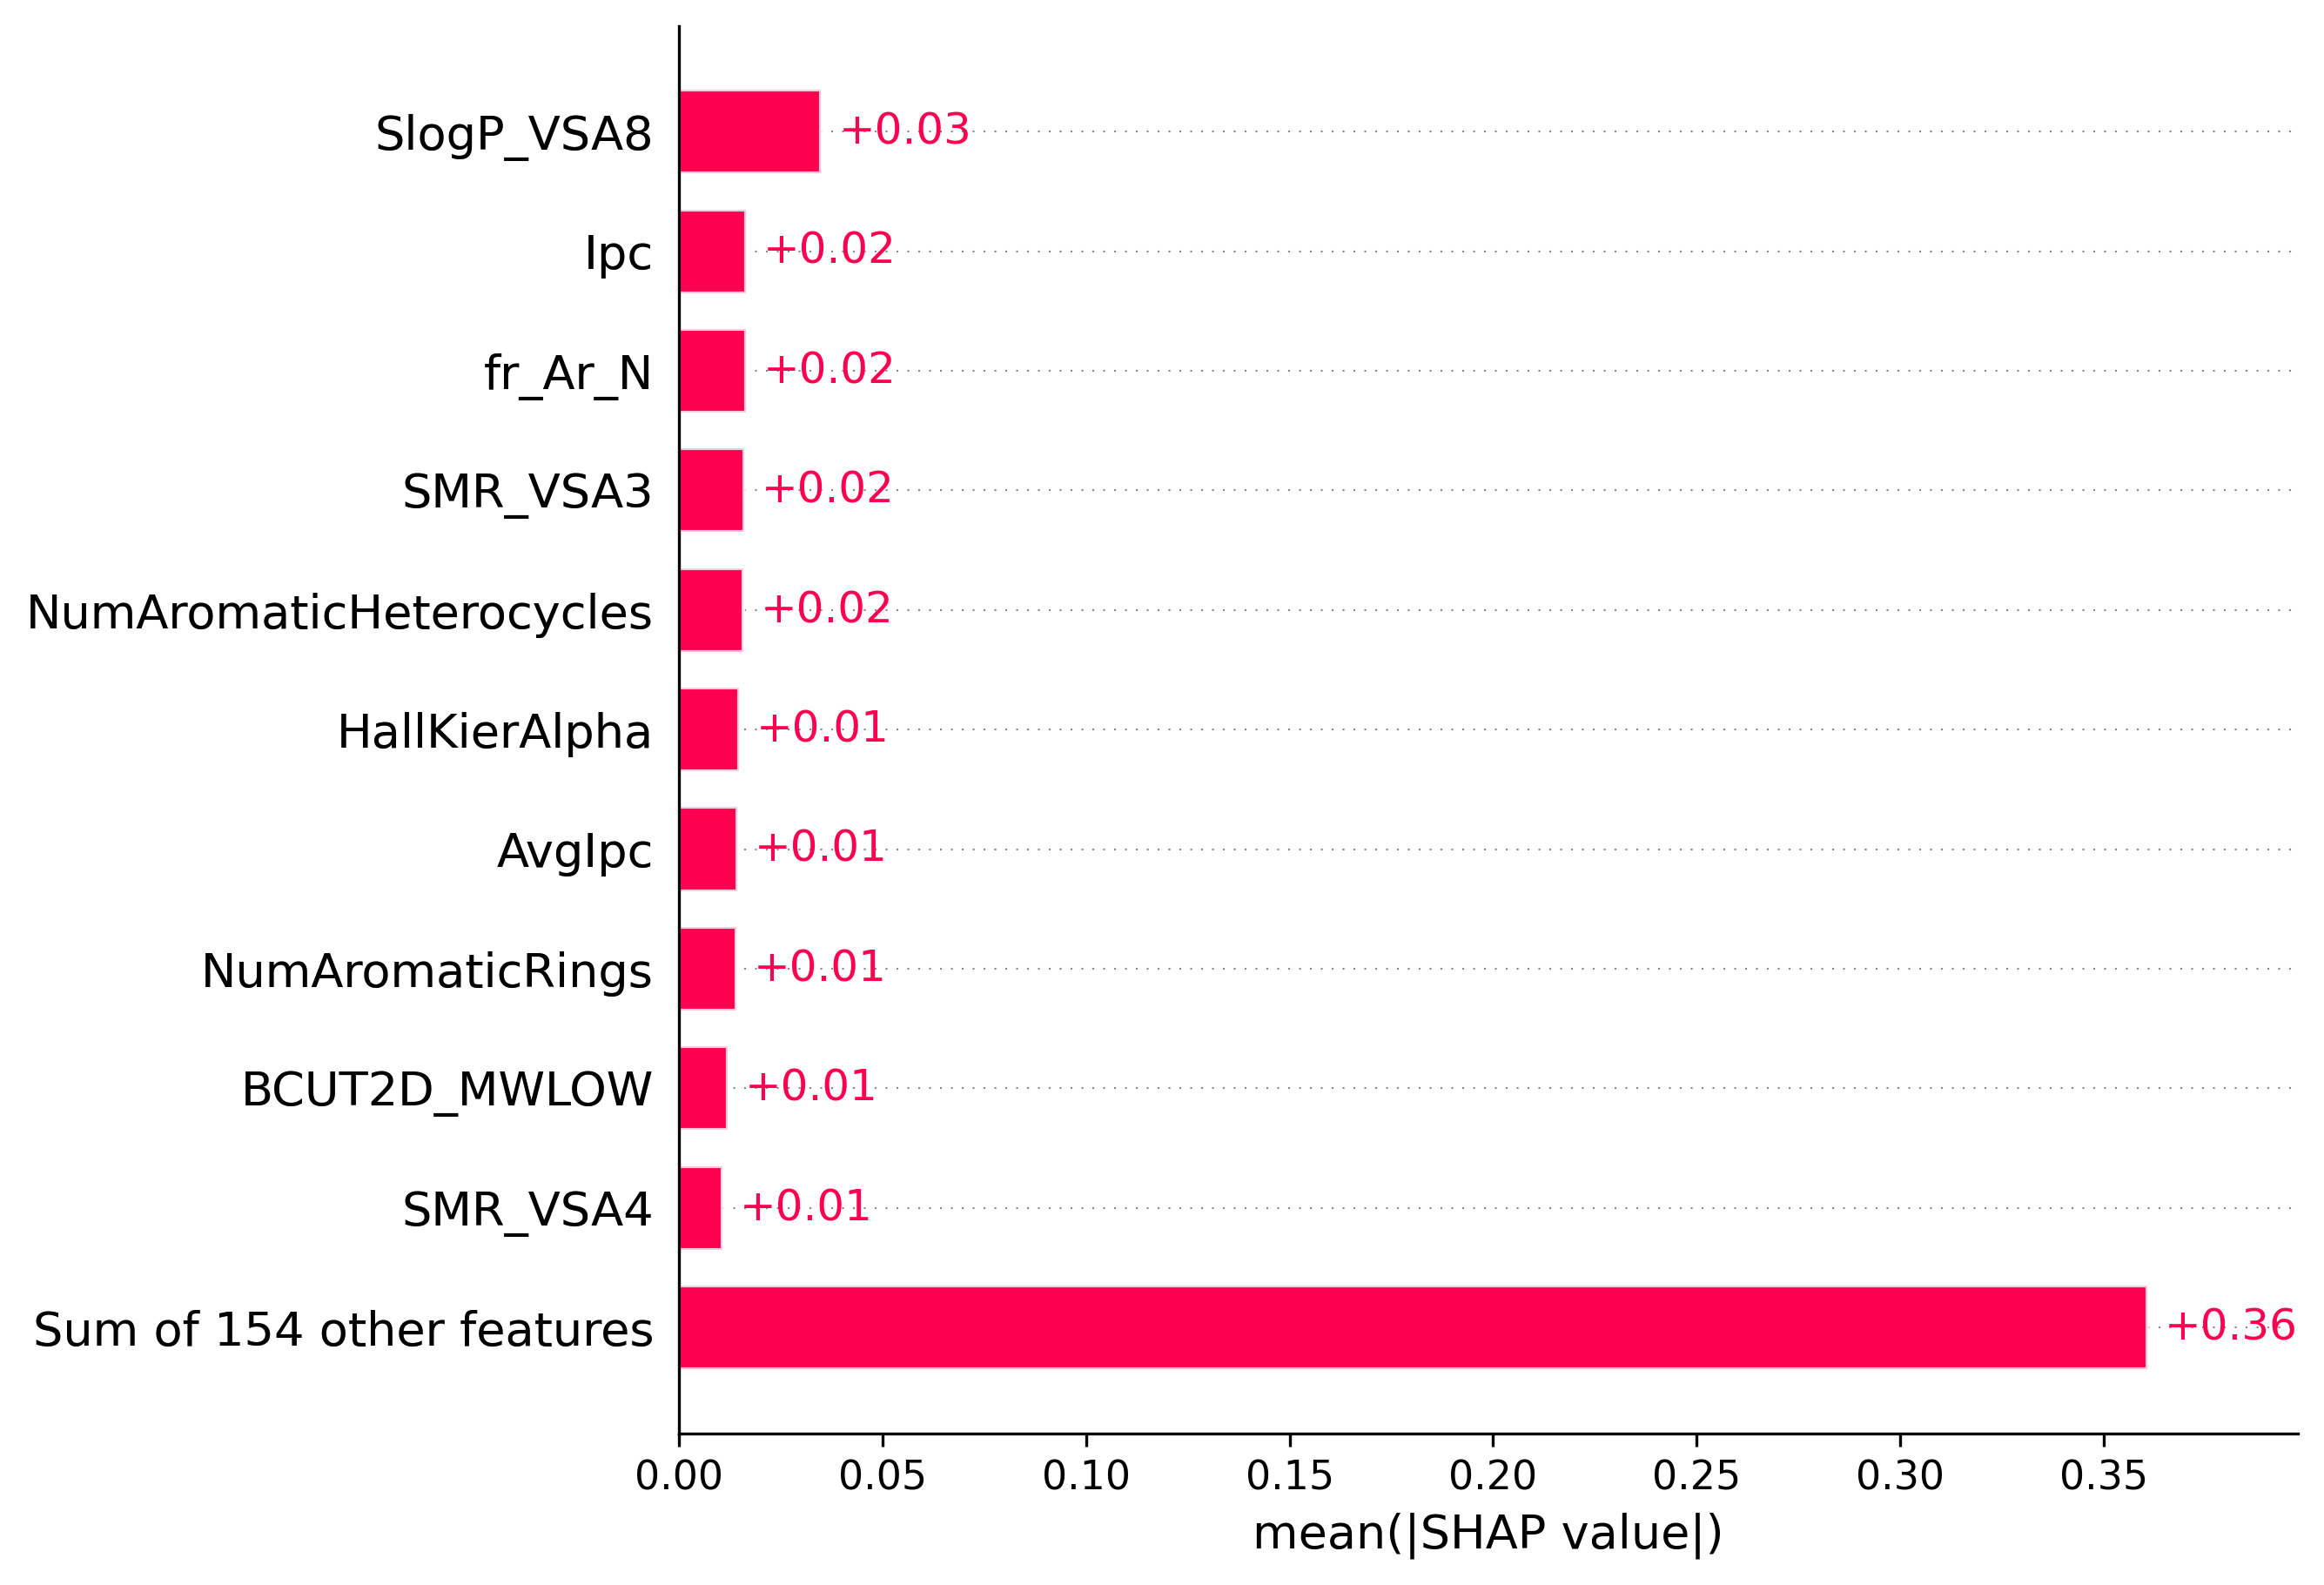

In [78]:
explainer2 = shap.Explainer(rf_model,feature_names = result)
shap_values2 = explainer2(test_dataset.X)
shap.plots.bar(shap_values2[:,:,1],  max_display=11)

# plot_experimental_compounds

In [20]:
exp_compounds = pd.read_excel('../../data/experimental compounds.xlsx')

In [21]:
exp_compounds_featrures = featurizer.featurize(exp_compounds['SMILES'])

In [22]:
mask = vt.get_support(indices=True)
exp_compounds_selected = exp_compounds_featrures[:, mask]

In [23]:
exp_compounds_prob = rf_model.predict_proba(exp_compounds_selected)

In [24]:
exp_compounds_prob

array([[0.01734524, 0.98265476],
       [0.13021992, 0.86978008],
       [0.183348  , 0.816652  ],
       [0.10483512, 0.89516488],
       [0.03650973, 0.96349027]])

In [25]:
shap_values_3 = explainer.shap_values(exp_compounds_selected)

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values_3[1],exp_compounds_featrures,feature_names = result)

# Carvacrol


In [32]:
exp_compounds_prob

array([[0.01734524, 0.98265476],
       [0.13021992, 0.86978008],
       [0.183348  , 0.816652  ],
       [0.10483512, 0.89516488],
       [0.03650973, 0.96349027]])

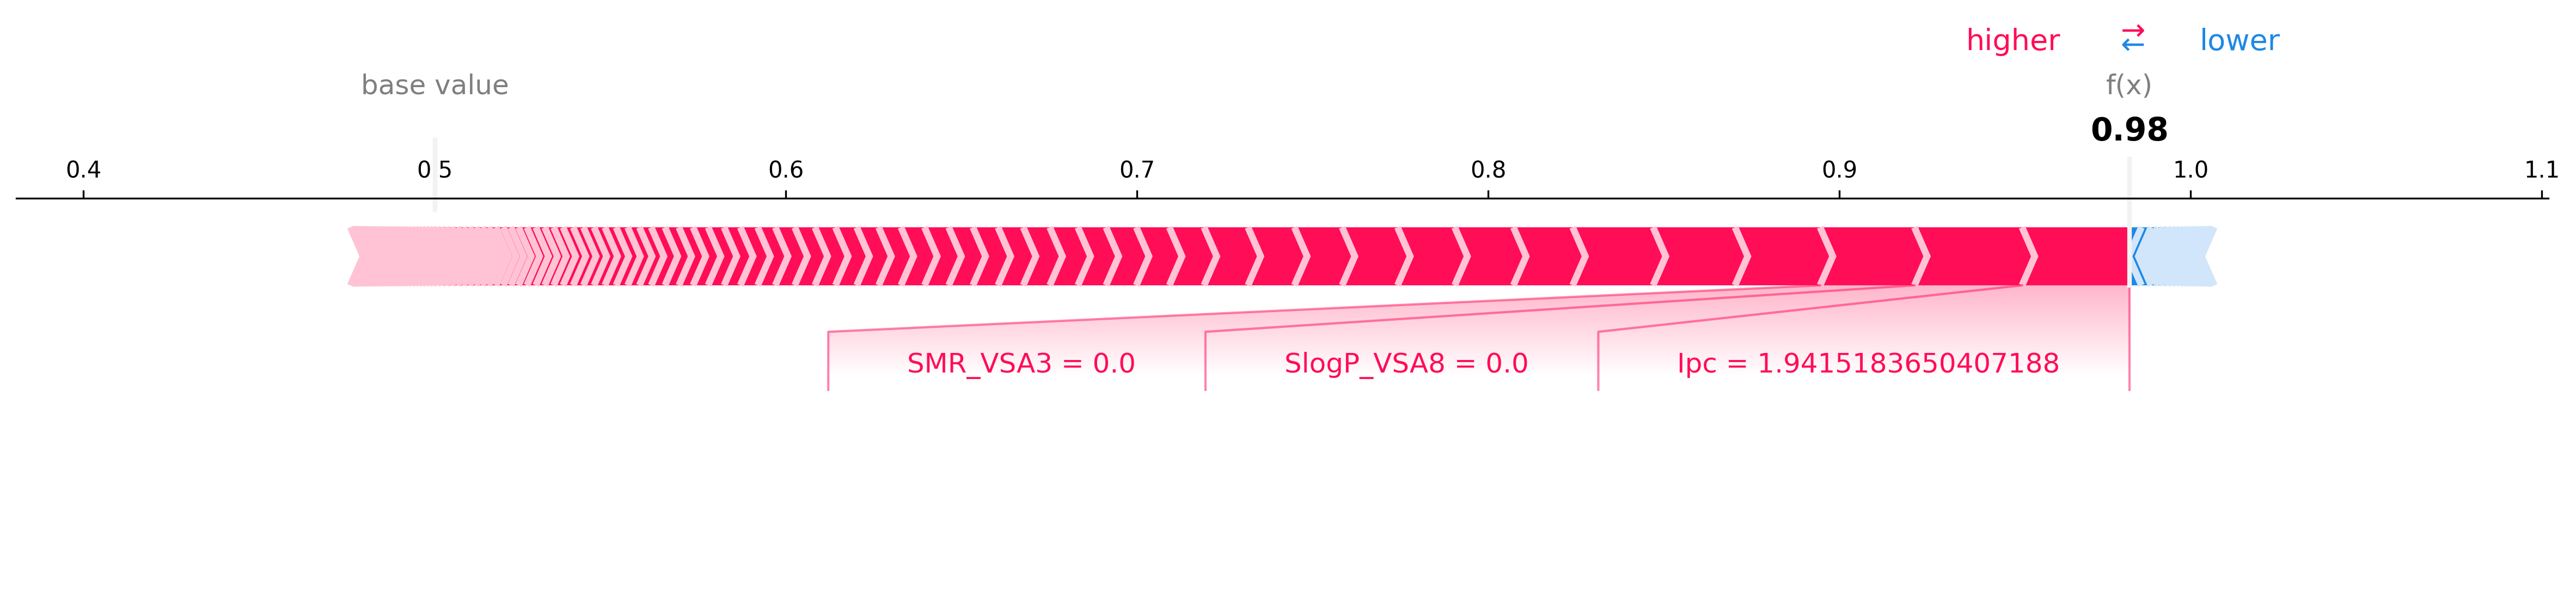

In [33]:
#fig = plt.figure()
sample = 0 #第几个样本
shap.force_plot(explainer.expected_value[1], #预测值为1
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample,:],
                feature_names=result,
                matplotlib=True,
              show = False
               )
#plt.savefig("./shap/force_plot.png") 
#plt.show()
#plt.clf()

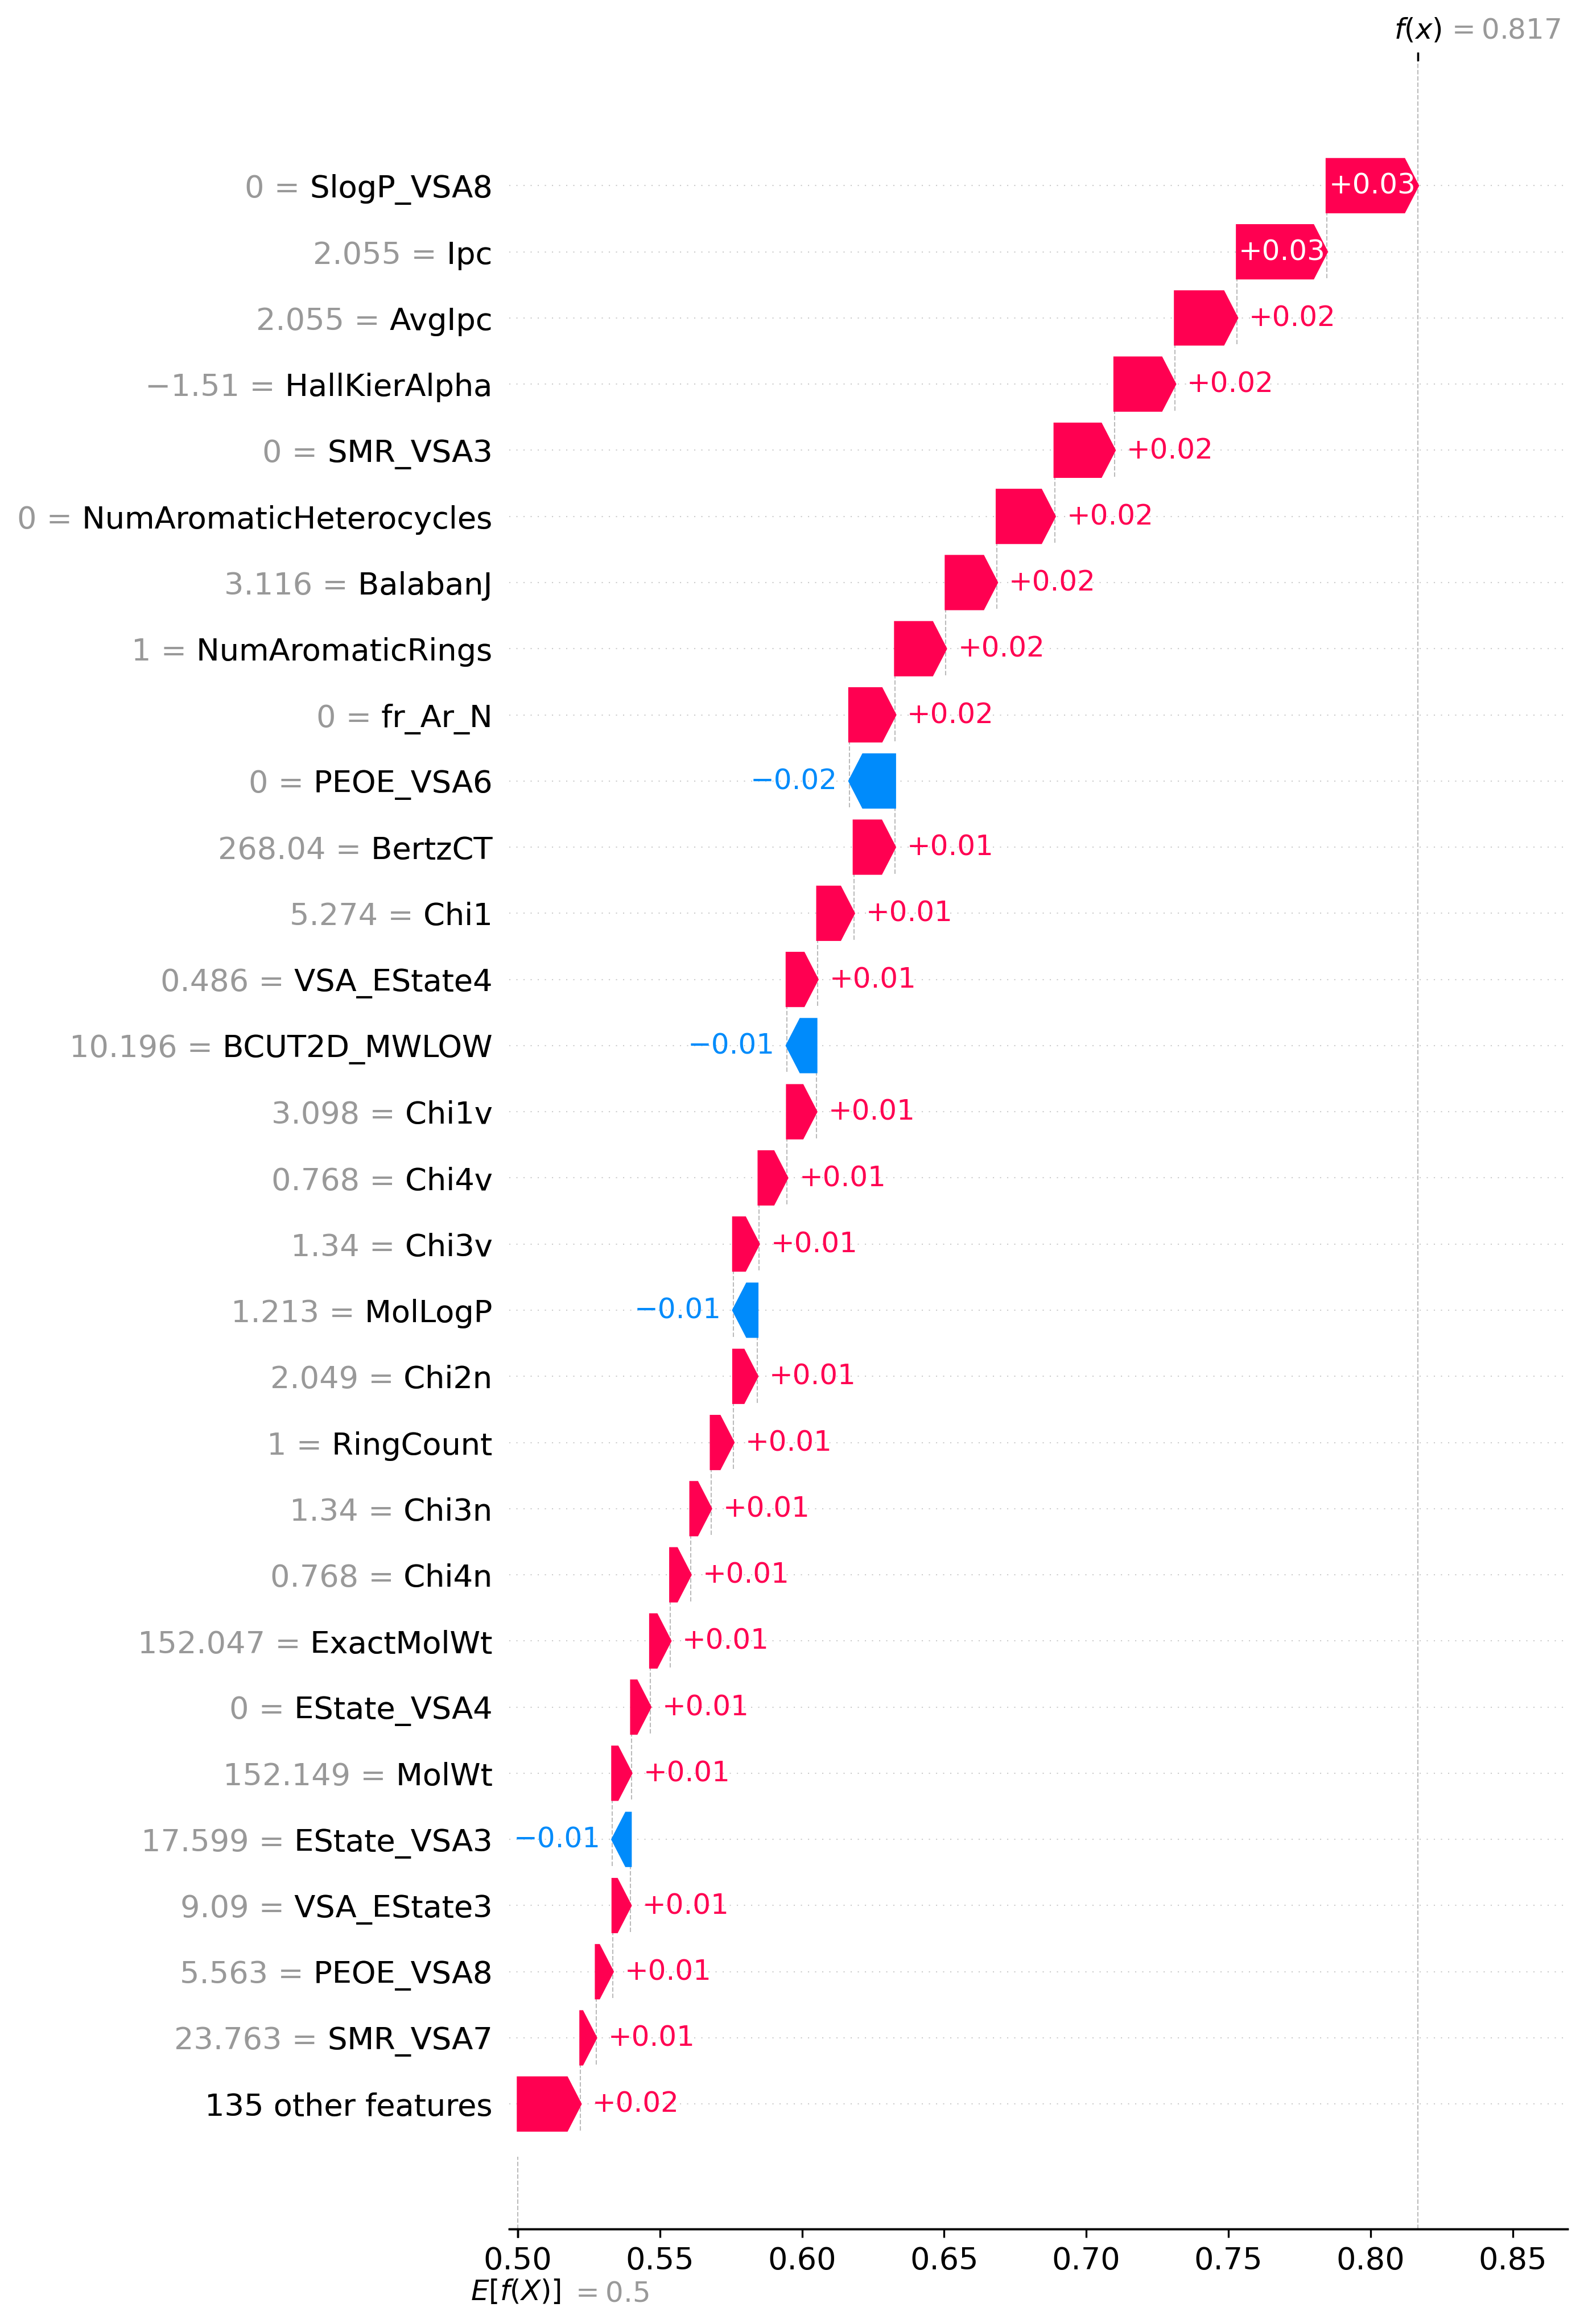

In [36]:
sample_idx = 2 #选择第几个样本
shap_value_sample = shap_values_3[1][sample_idx]

# fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                      max_display=30,
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
plt.clf()

# Safranal


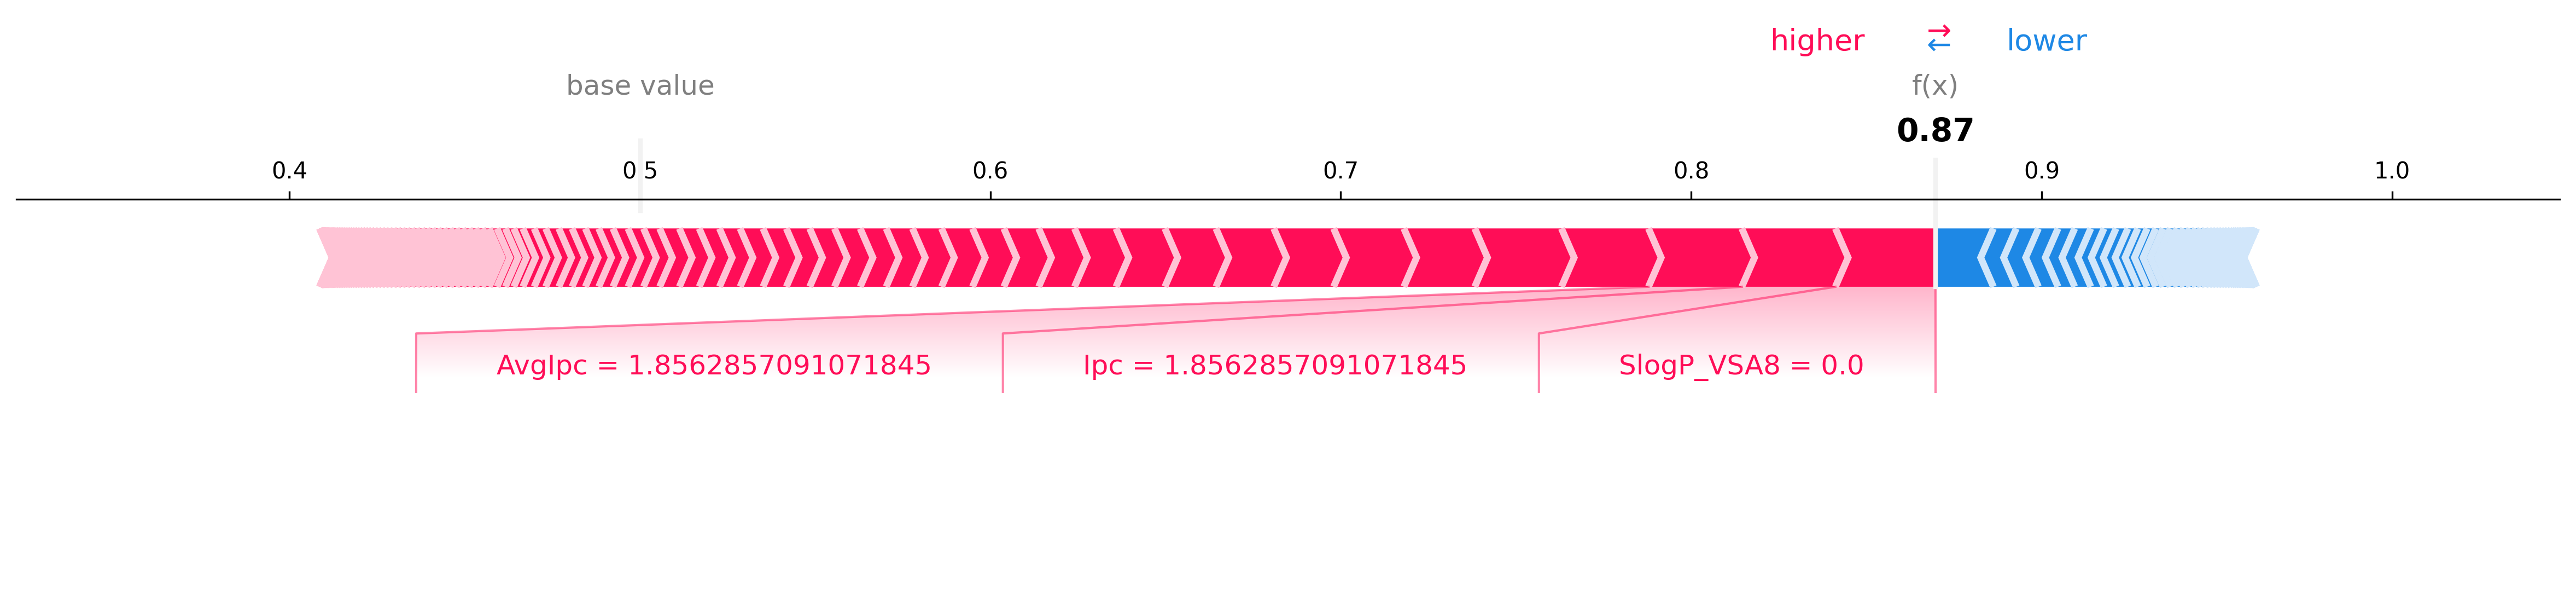

In [72]:
#fig = plt.figure()
sample = 1 #第几个样本
shap.force_plot(explainer.expected_value[1], #预测值为1
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

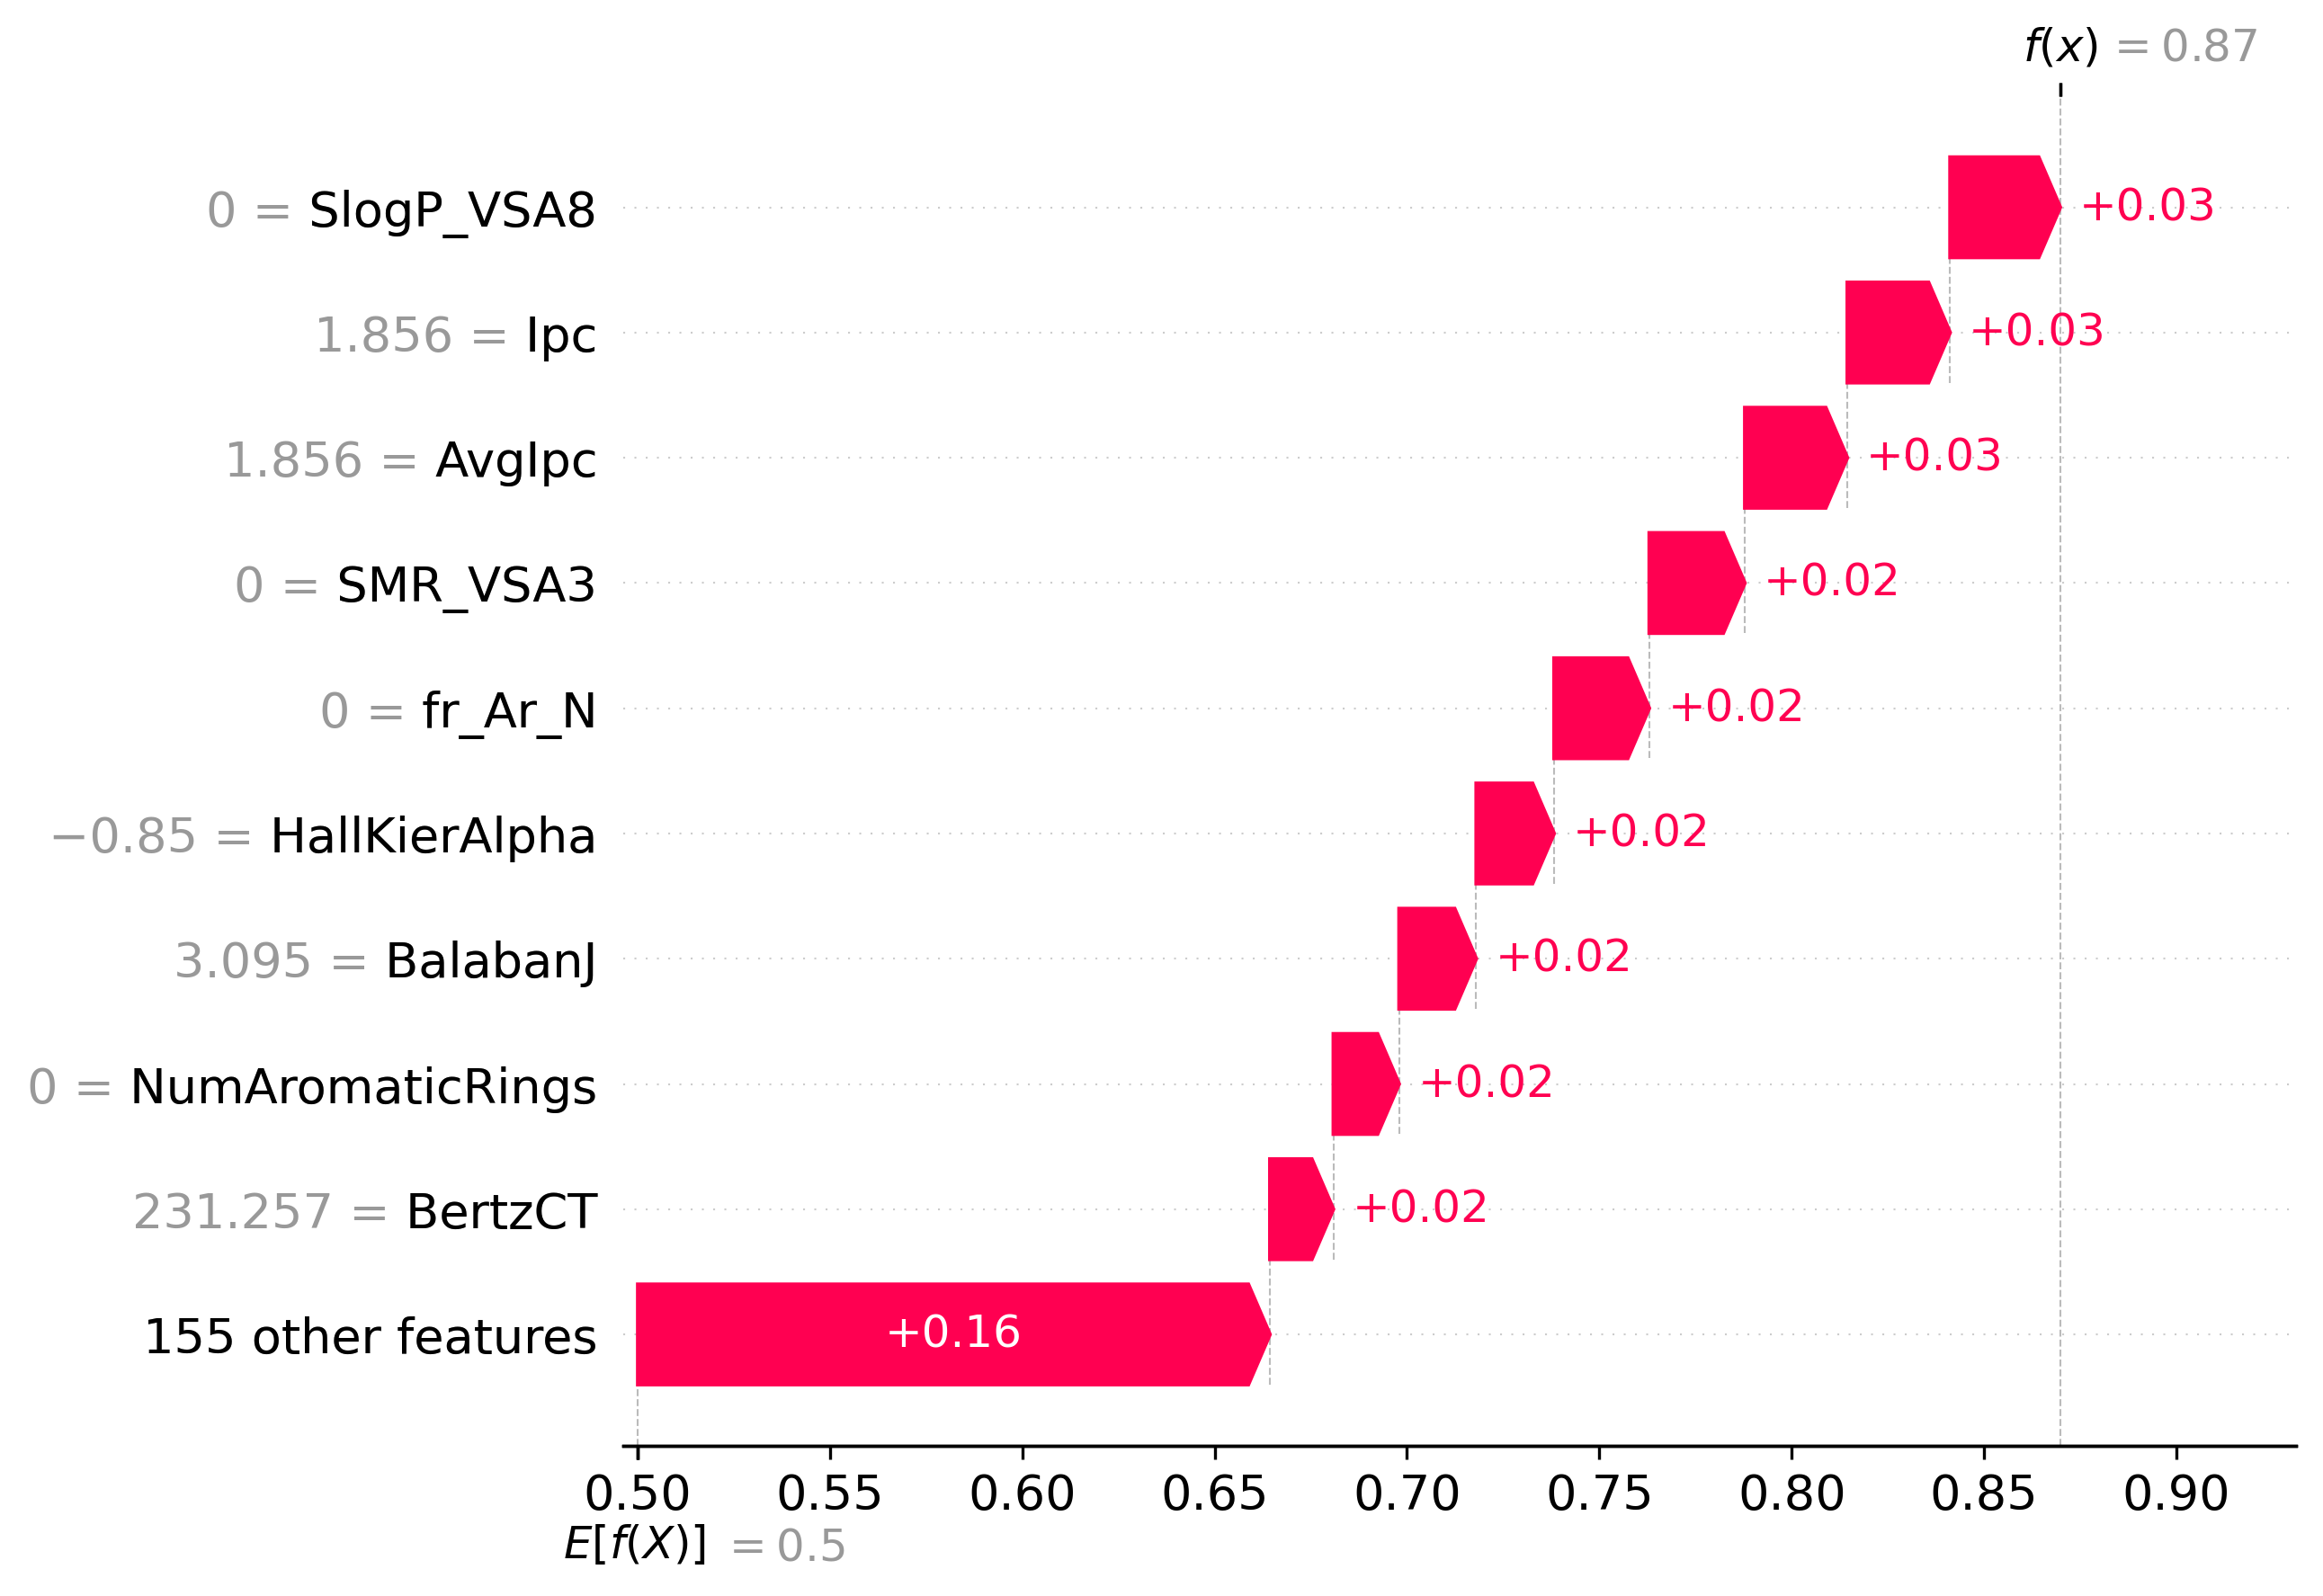

In [73]:
sample_idx = 1 #选择第几个样本
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Vanillin


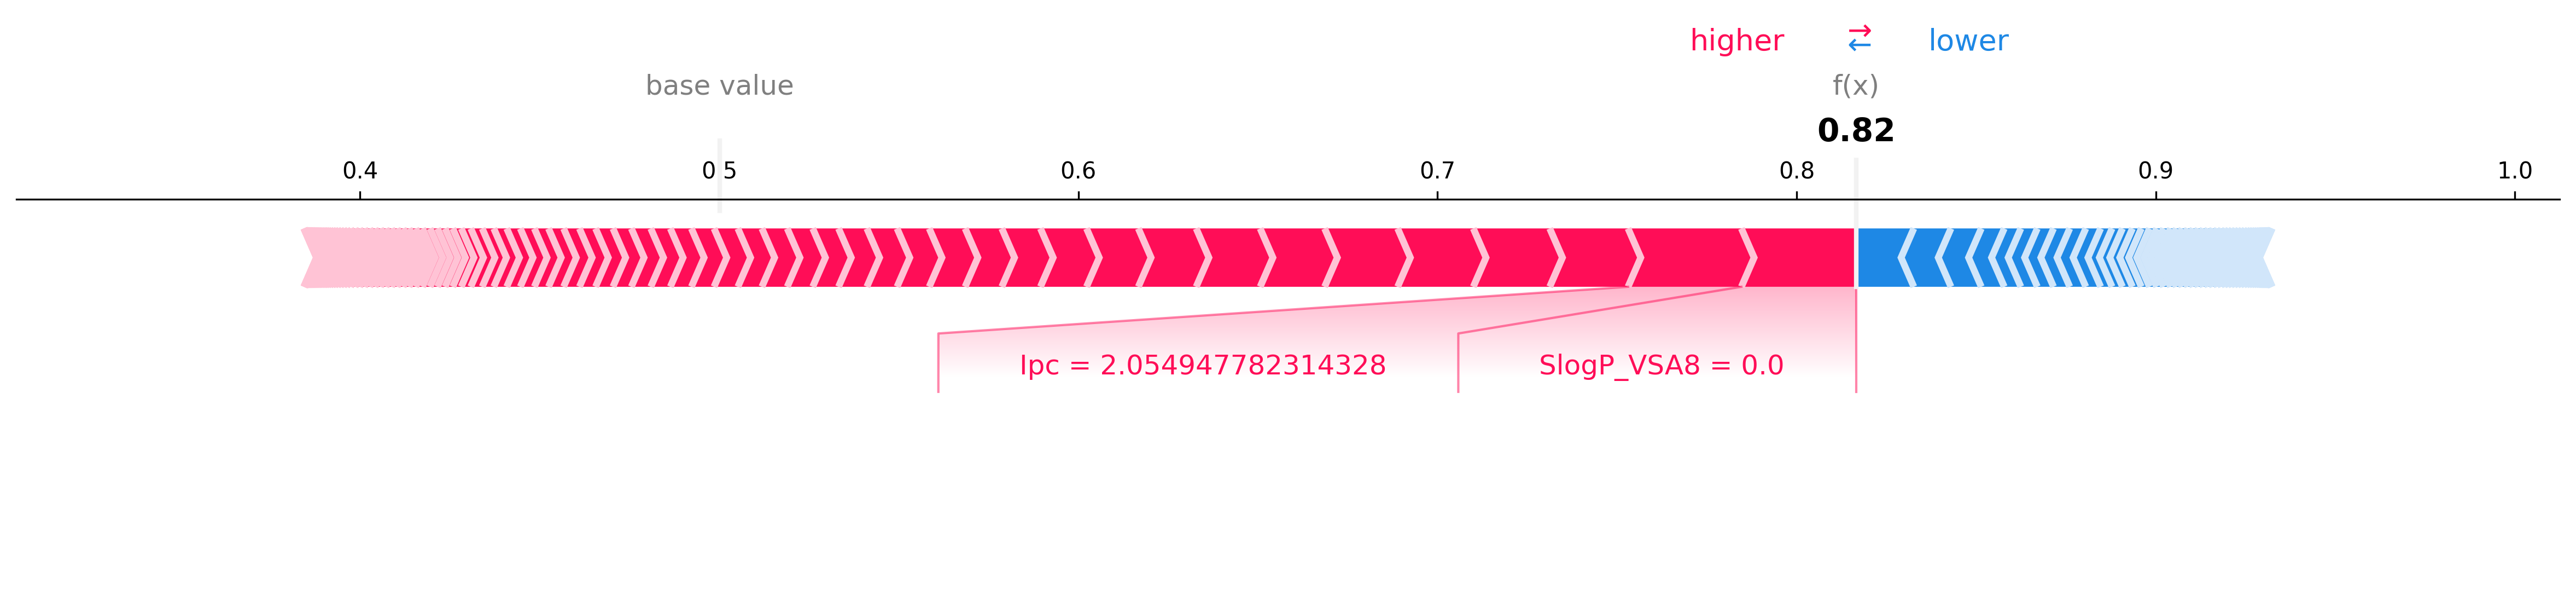

In [74]:
#fig = plt.figure()
sample = 2 #第几个样本
shap.force_plot(explainer.expected_value[1], #预测值为1
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

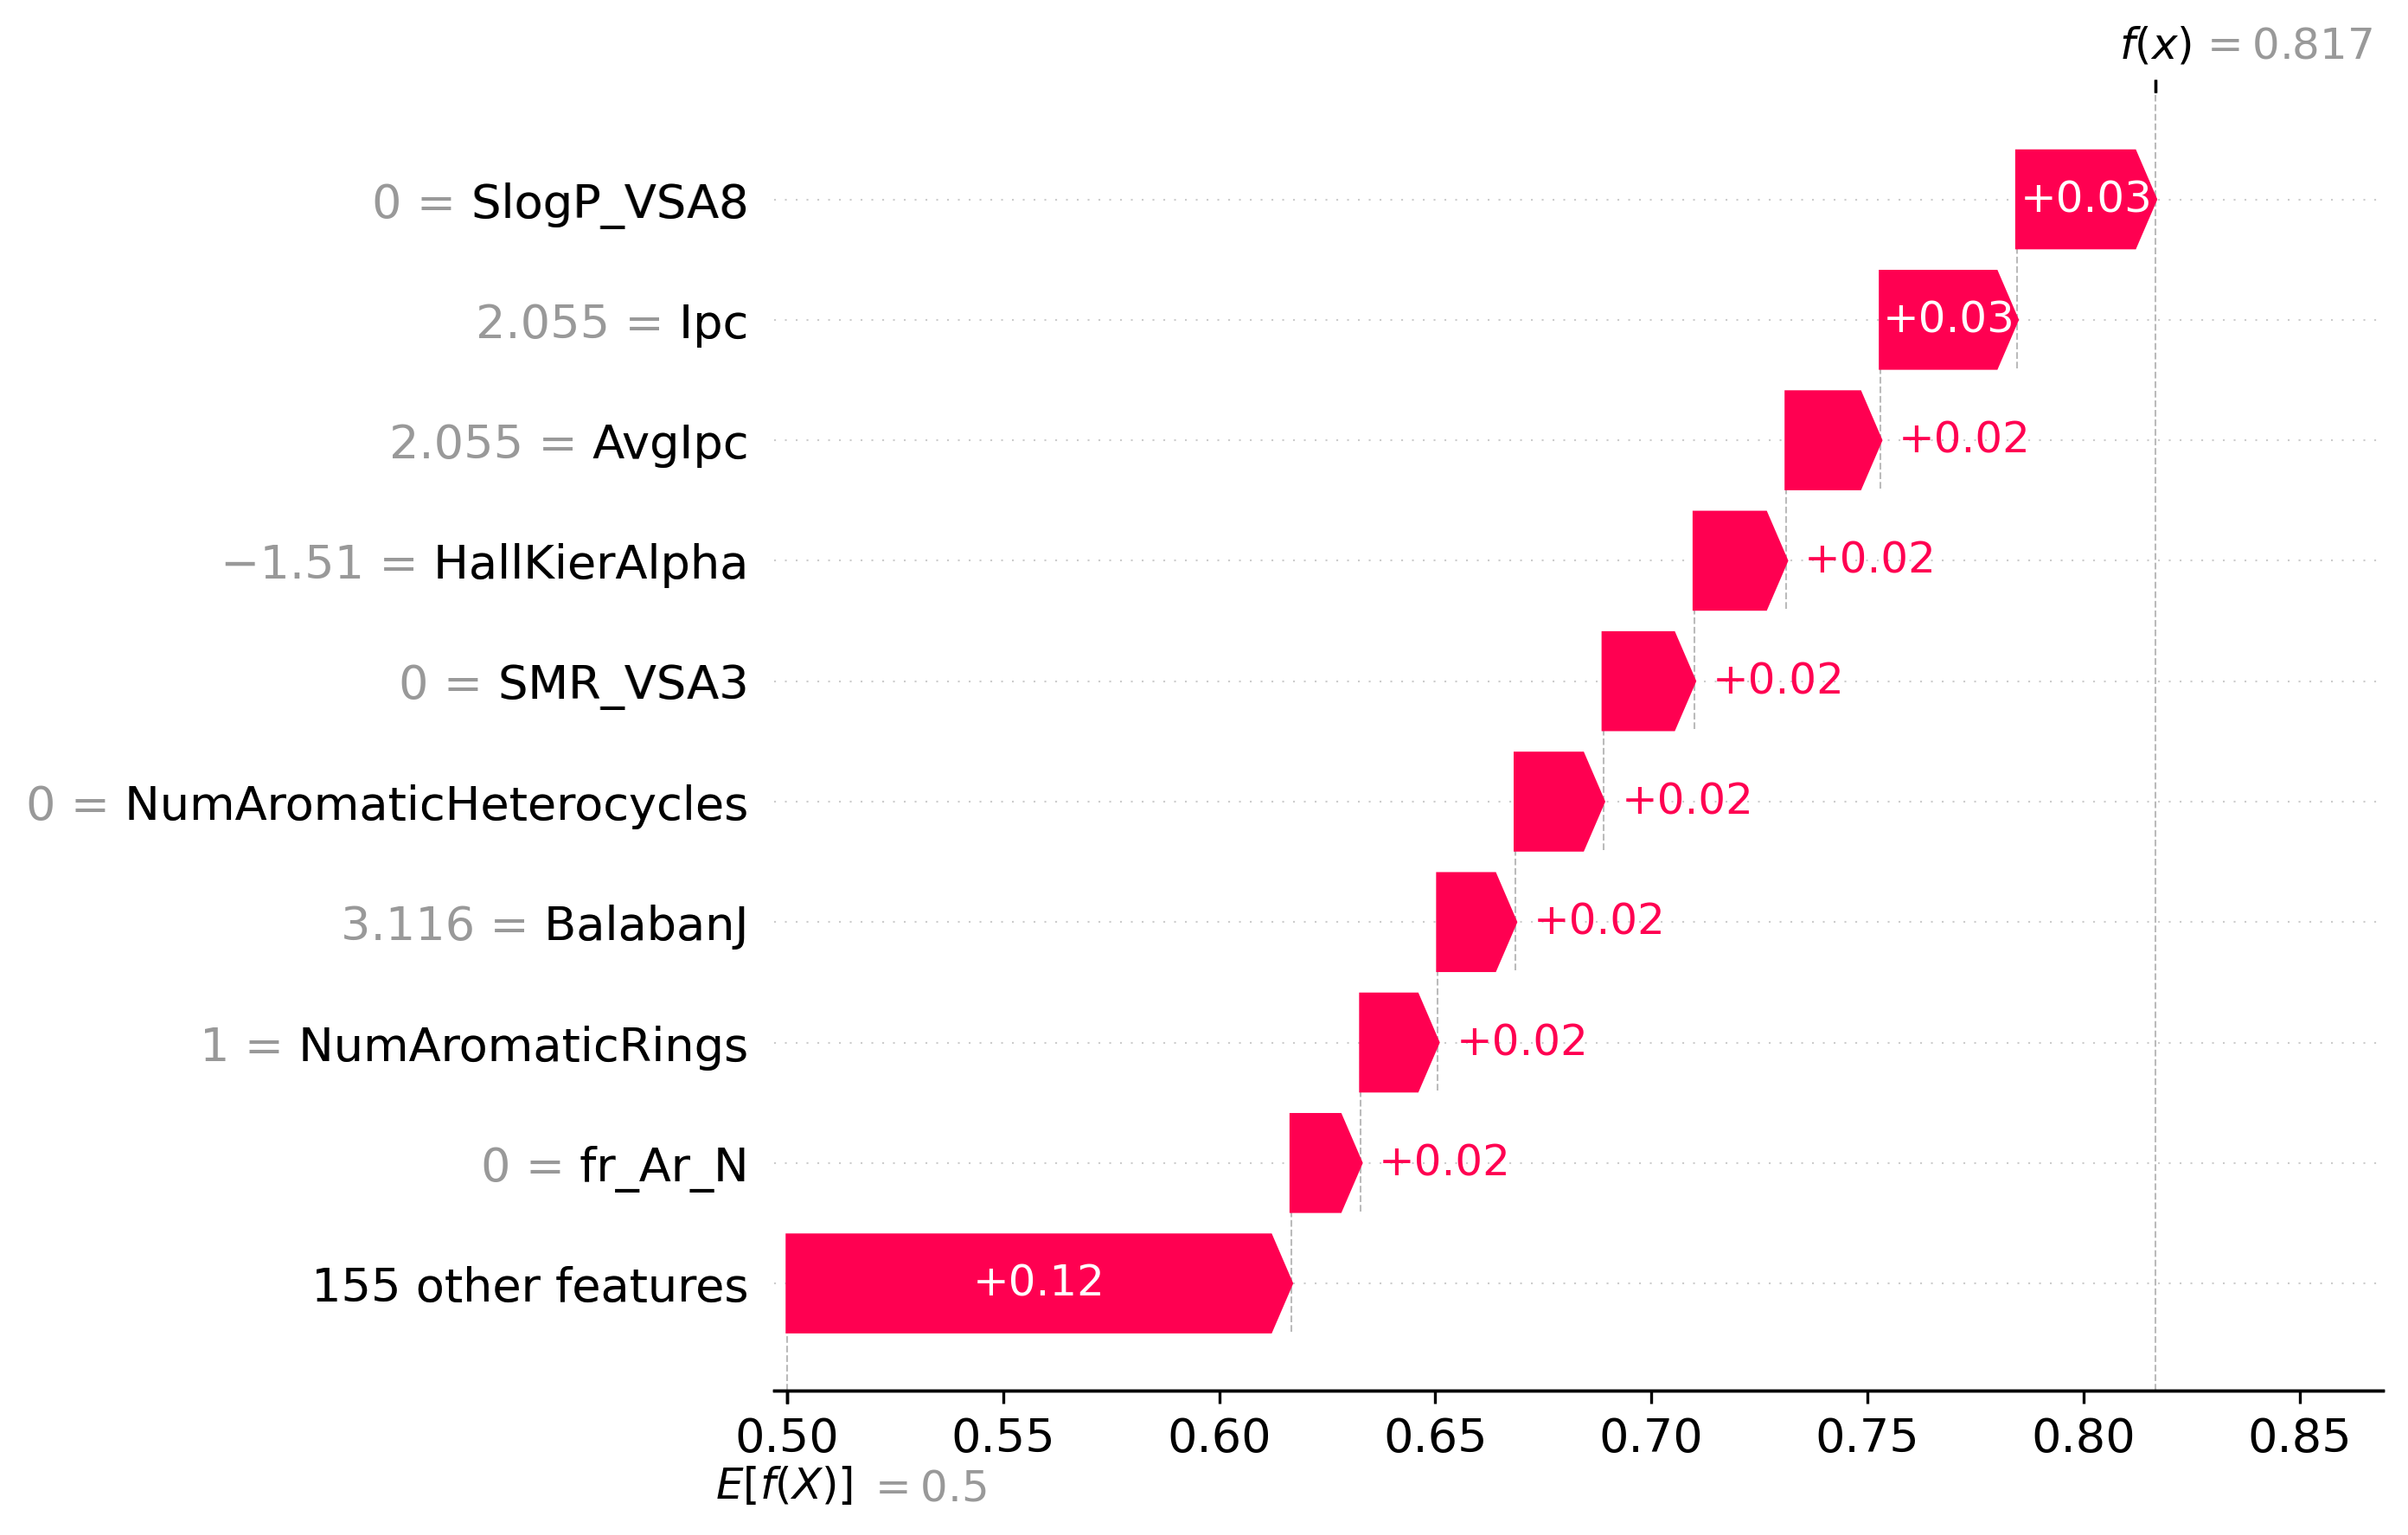

In [75]:
sample_idx = 2 #选择第几个样本
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Methyleugenol

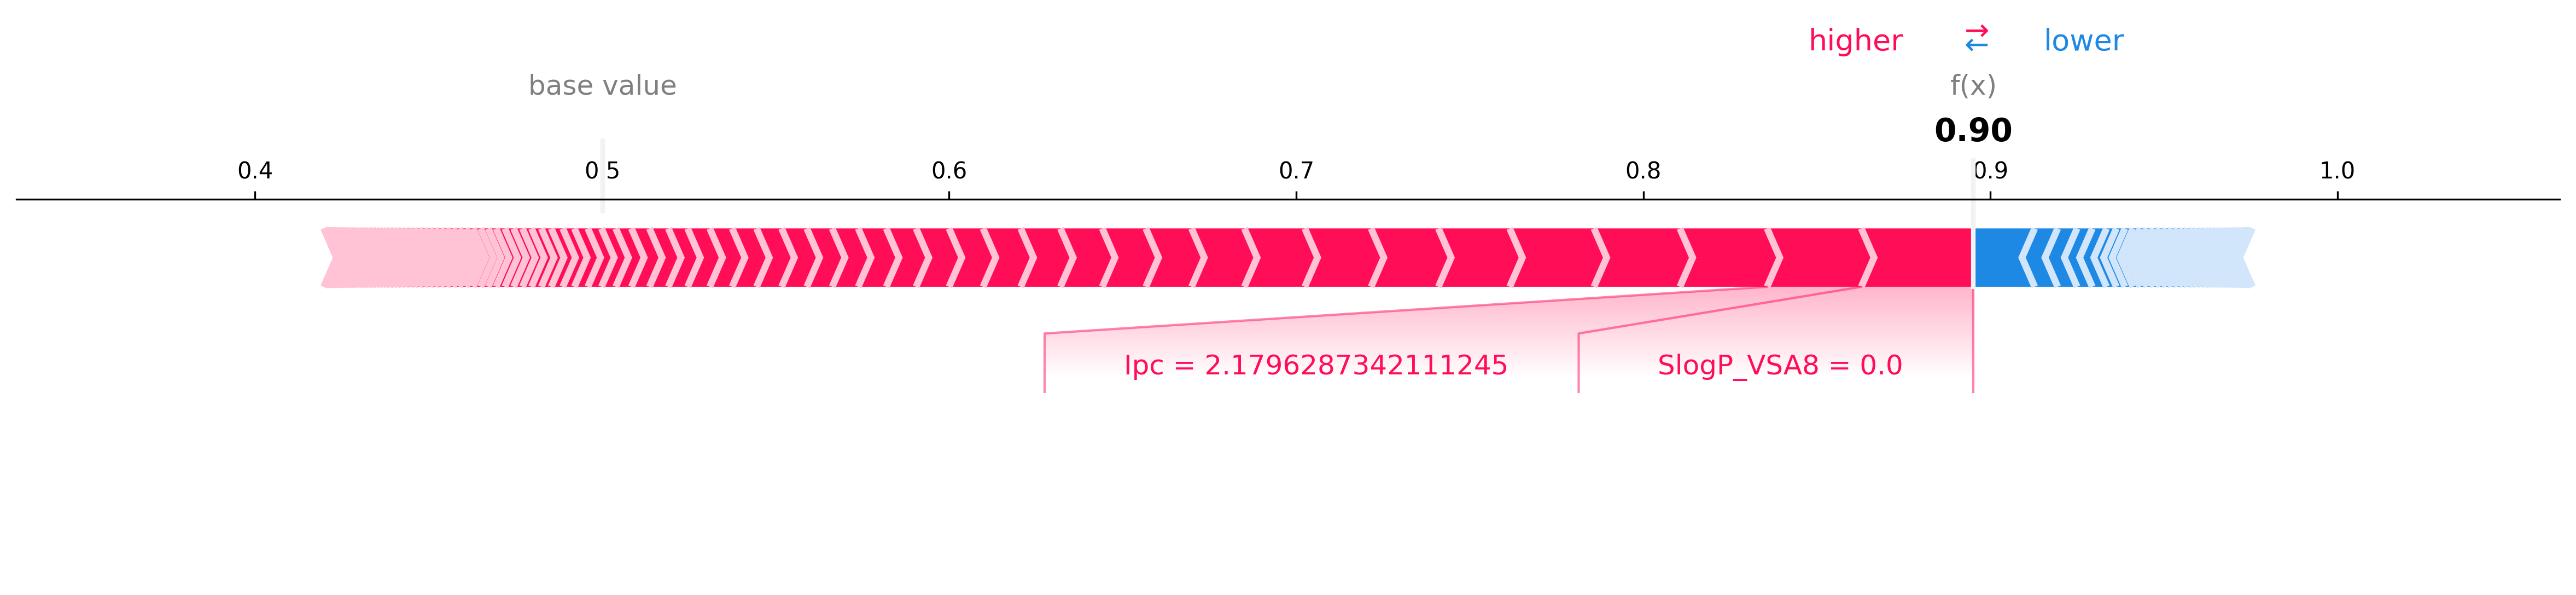

In [76]:
#fig = plt.figure()
sample = 3 #第几个样本
shap.force_plot(explainer.expected_value[1], #预测值为1
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

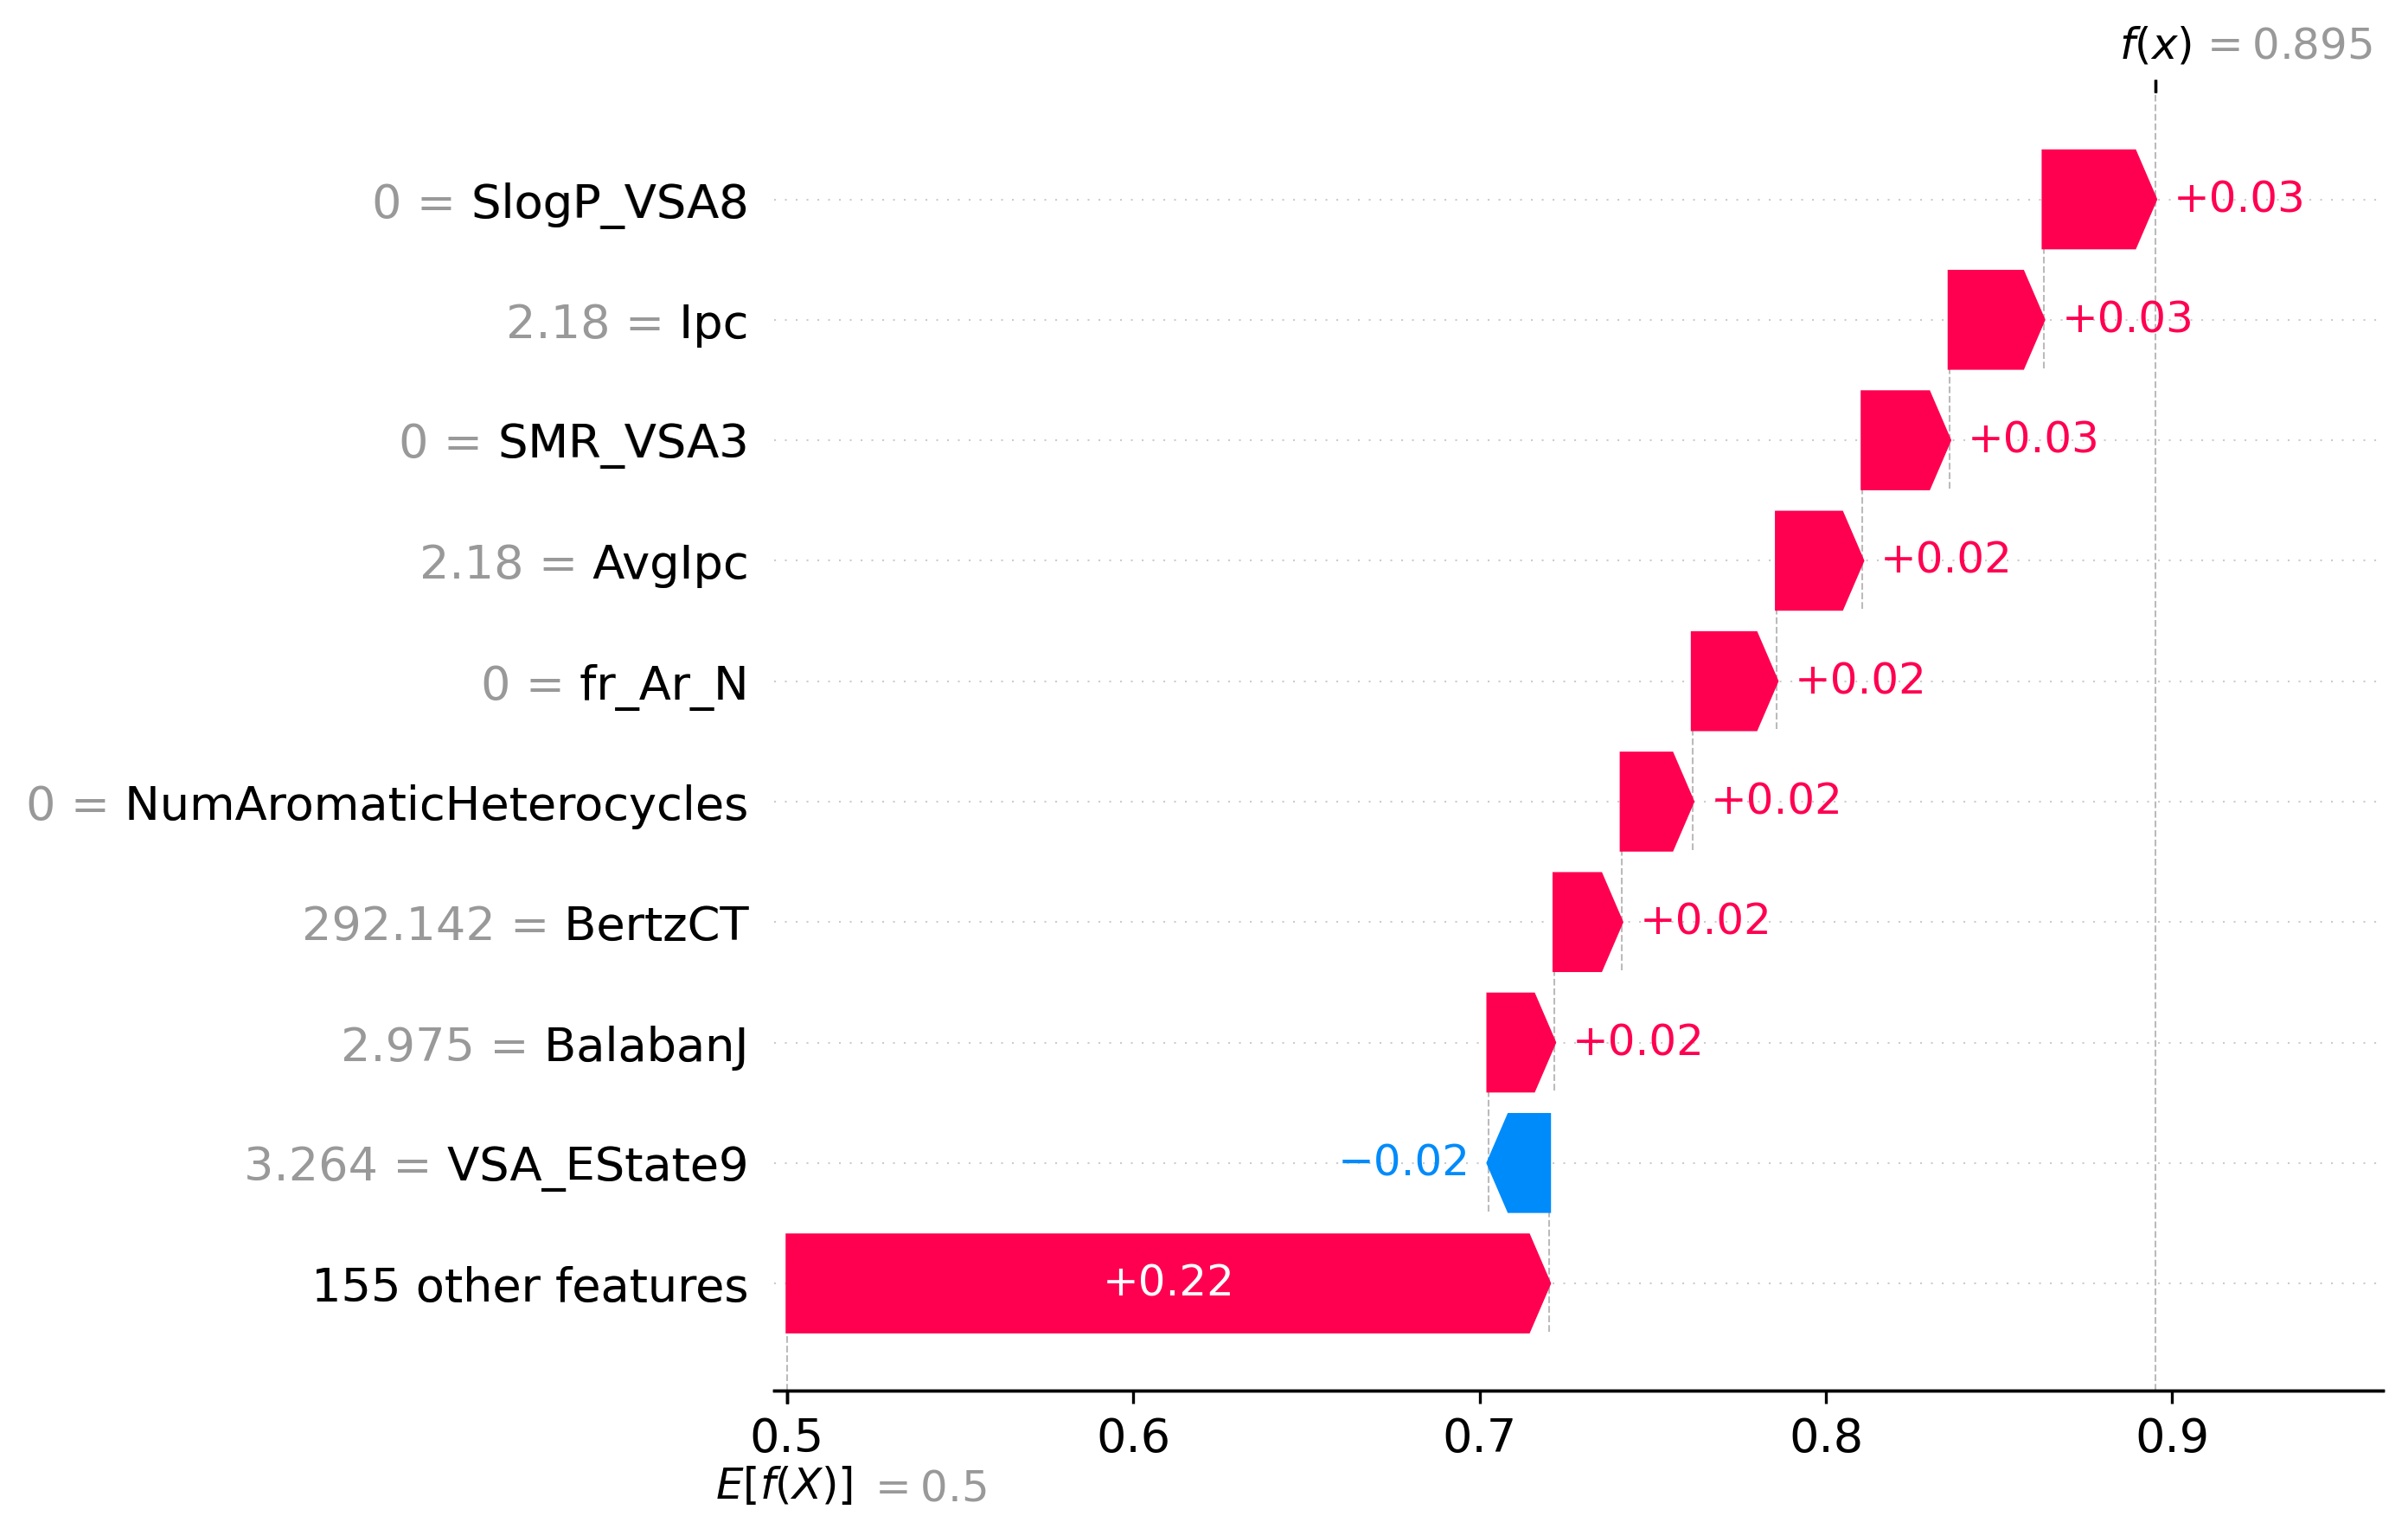

In [77]:
sample_idx = 3 #选择第几个样本
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Linalool

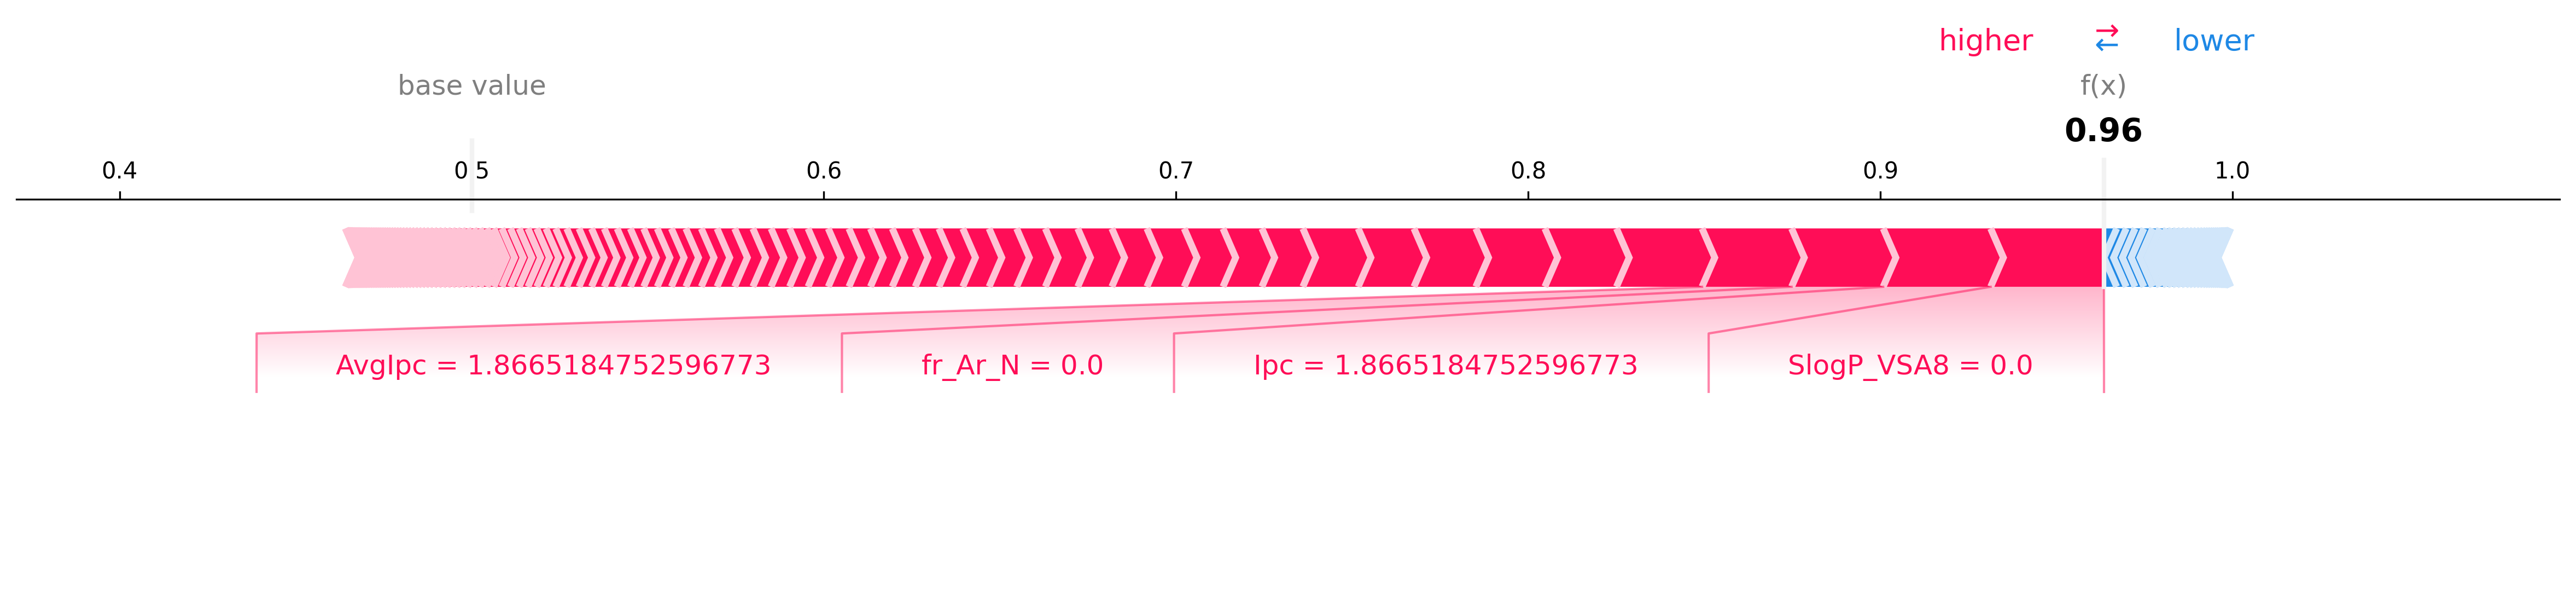

In [26]:
#fig = plt.figure()
sample = 4 #第几个样本
shap.force_plot(explainer.expected_value[1], #预测值为1
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

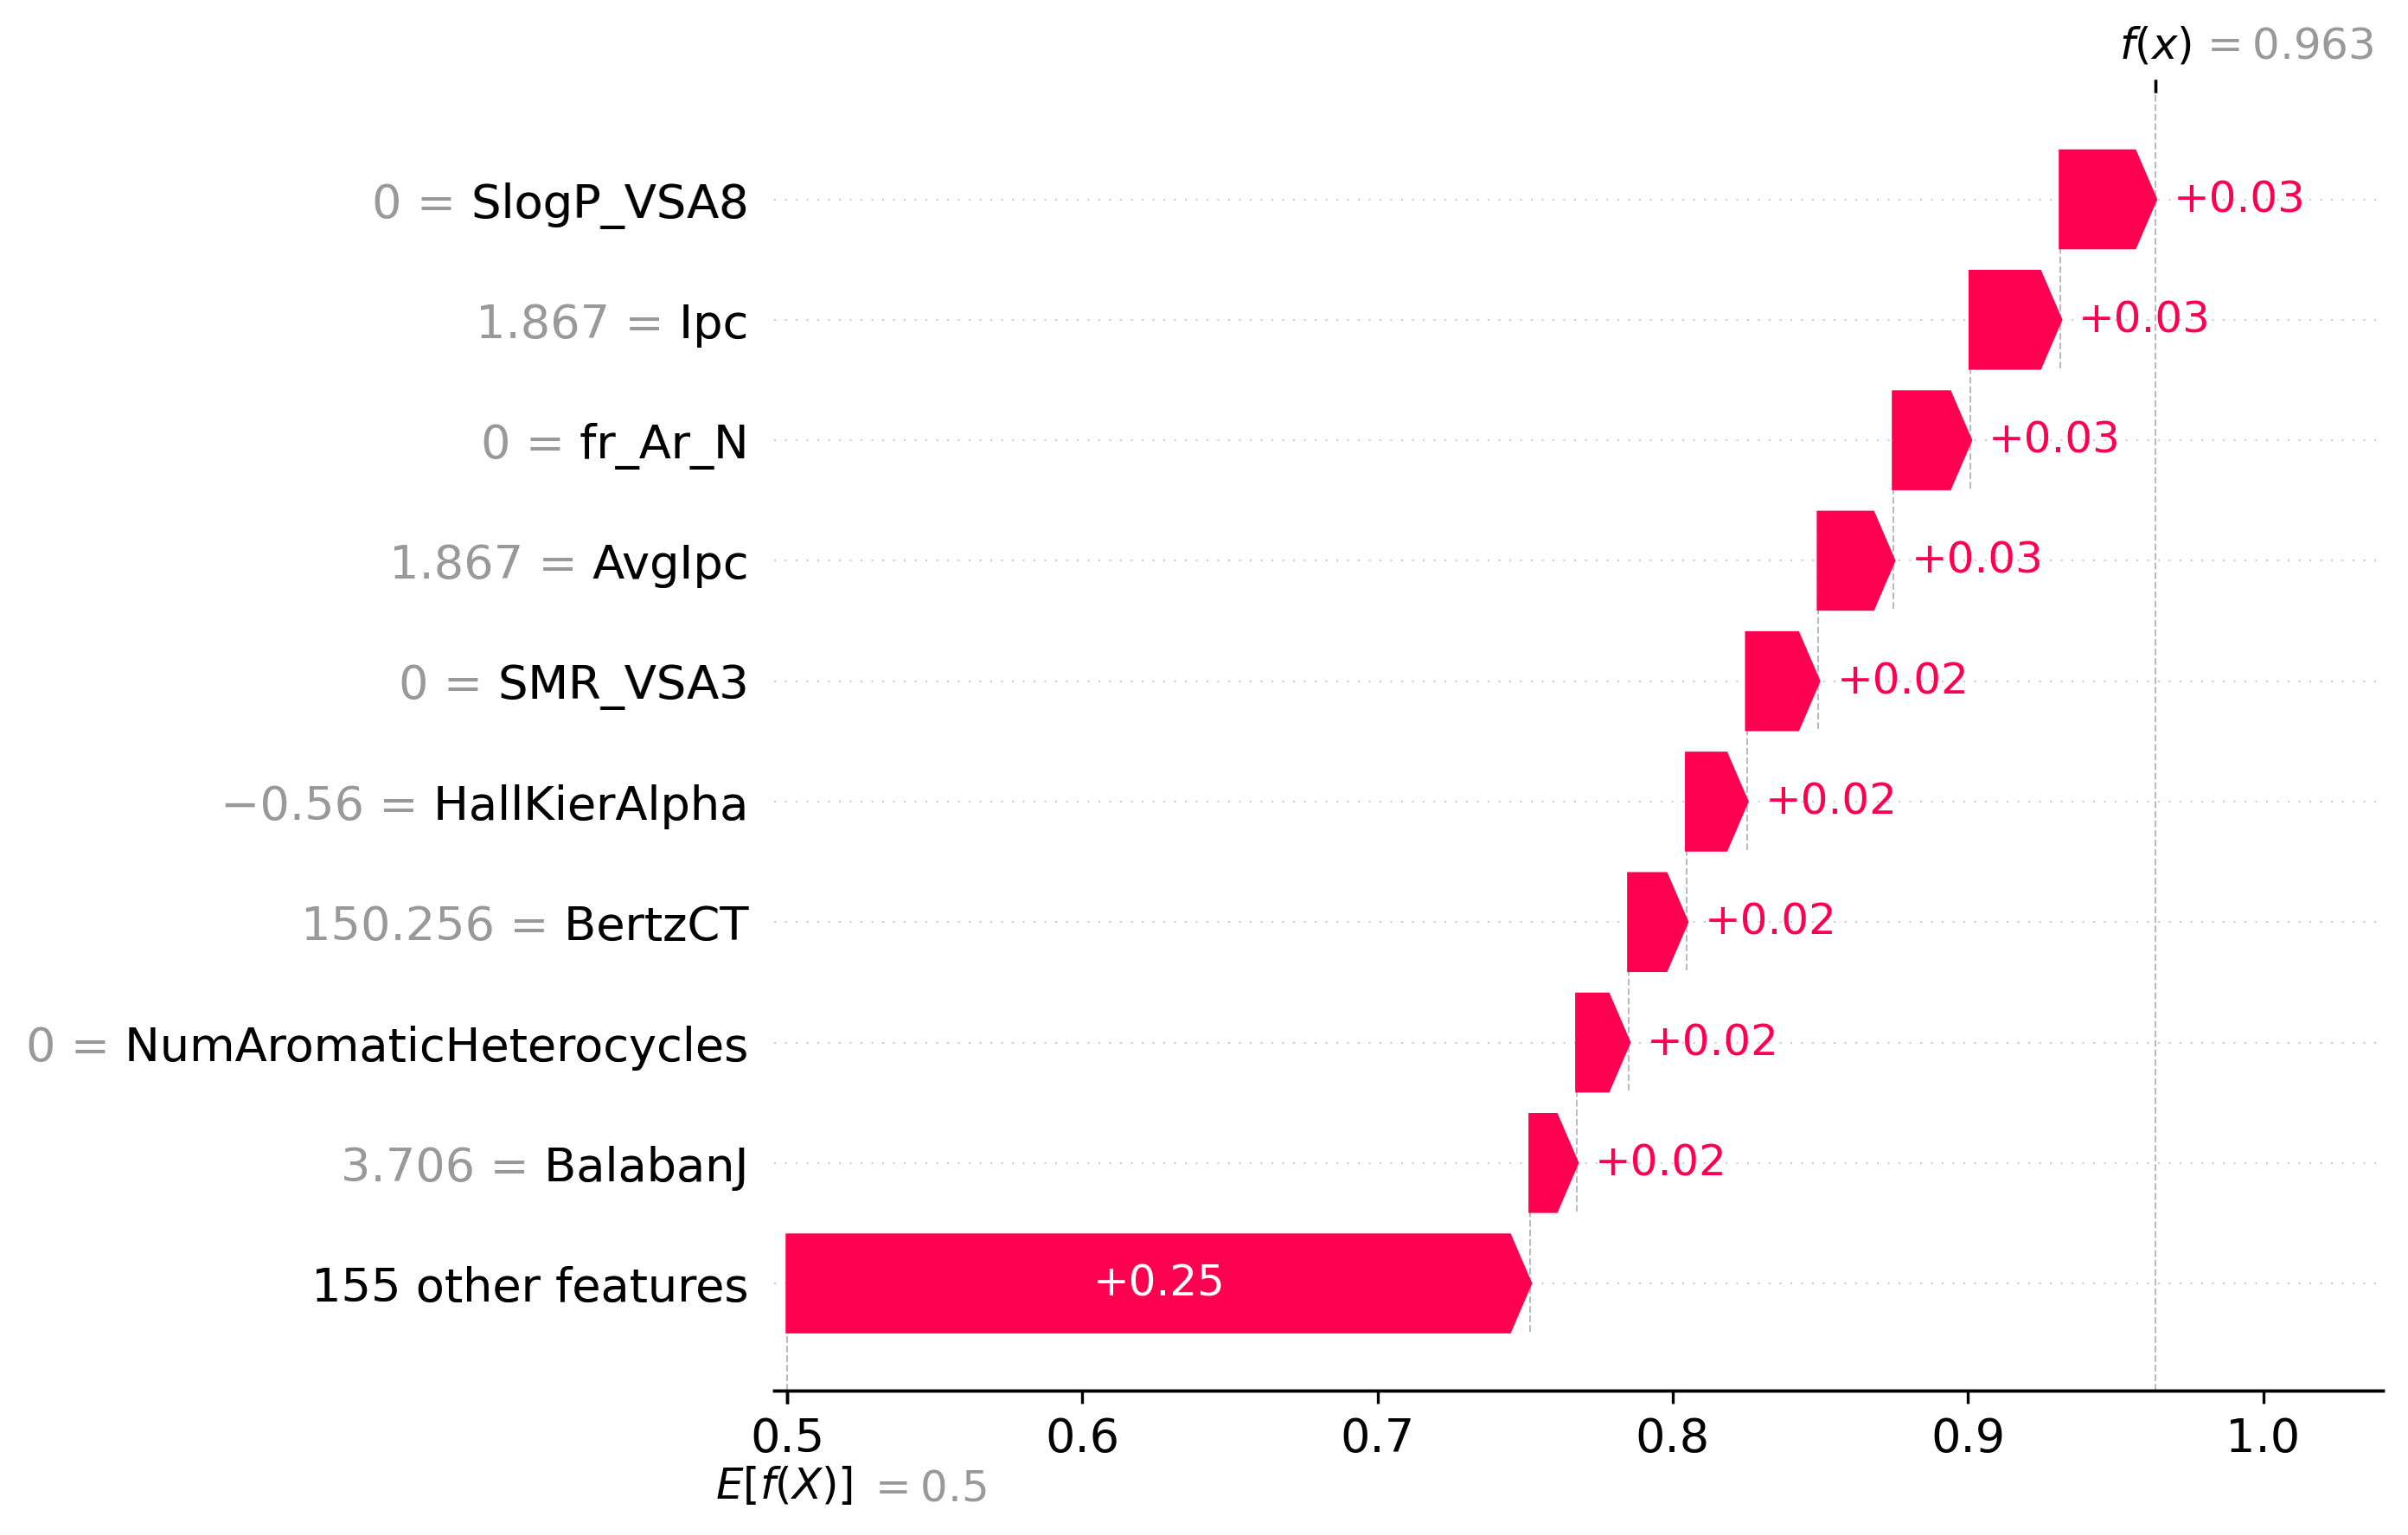

In [27]:
sample_idx = 4 #选择第几个样本
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()